In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True, font_scale=1.5)
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from IPython.display import display
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#spark=pd.read_csv('Sparkling.csv',parse_dates=True,index_col=0)
spark=pd.read_csv('Sparkling.csv')

In [3]:
display(spark.head())
display(spark.tail())

YearMonth  Sparkling
0   1980-01       1686
1   1980-02       1591
2   1980-03       2304
3   1980-04       1712
4   1980-05       1471

YearMonth  Sparkling
182   1995-03       1897
183   1995-04       1862
184   1995-05       1670
185   1995-06       1688
186   1995-07       2031

In [4]:
spark.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YearMonth  187 non-null    object
 1   Sparkling  187 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [5]:
date = pd.date_range(start='1/1/1980', end='1/1/1996', freq='M')
date

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '1995-03-31', '1995-04-30', '1995-05-31', '1995-06-30',
               '1995-07-31', '1995-08-31', '1995-09-30', '1995-10-31',
               '1995-11-30', '1995-12-31'],
              dtype='datetime64[ns]', length=192, freq='M')

In [6]:
spark['Time_Stamp'] = pd.DataFrame(date,columns=['YearMonth'])
spark.head()

YearMonth  Sparkling Time_Stamp
0   1980-01       1686 1980-01-31
1   1980-02       1591 1980-02-29
2   1980-03       2304 1980-03-31
3   1980-04       1712 1980-04-30
4   1980-05       1471 1980-05-31

In [7]:
spark = spark.set_index('Time_Stamp')
spark.drop(['YearMonth'], axis=1, inplace=True)
spark.head()

Sparkling
Time_Stamp           
1980-01-31       1686
1980-02-29       1591
1980-03-31       2304
1980-04-30       1712
1980-05-31       1471

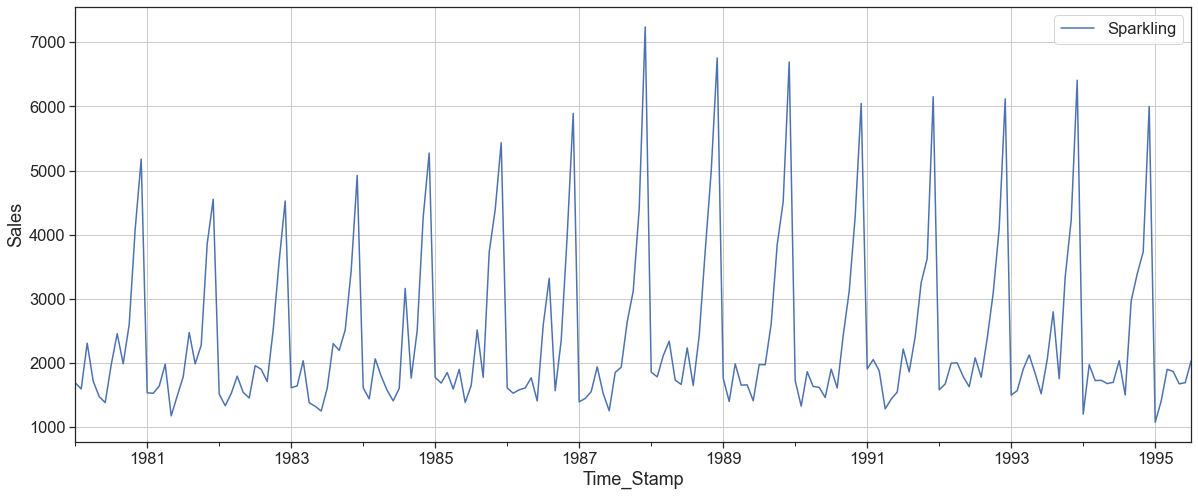

In [8]:
spark.plot(figsize=(20,8))
plt.ylabel("Sales")
plt.grid();

In [9]:
round(spark.describe(),3)

Sparkling
count    187.000
mean    2402.417
std     1295.112
min     1070.000
25%     1605.000
50%     1874.000
75%     2549.000
max     7242.000

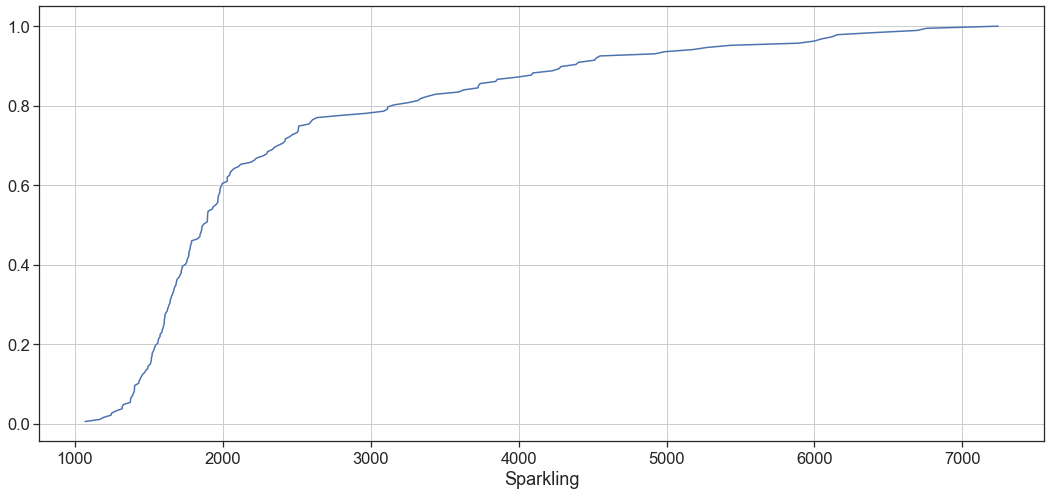

In [10]:
plt.figure(figsize=(18, 8))
cdf=ECDF(spark['Sparkling'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.grid()
plt.xlabel('Sparkling');

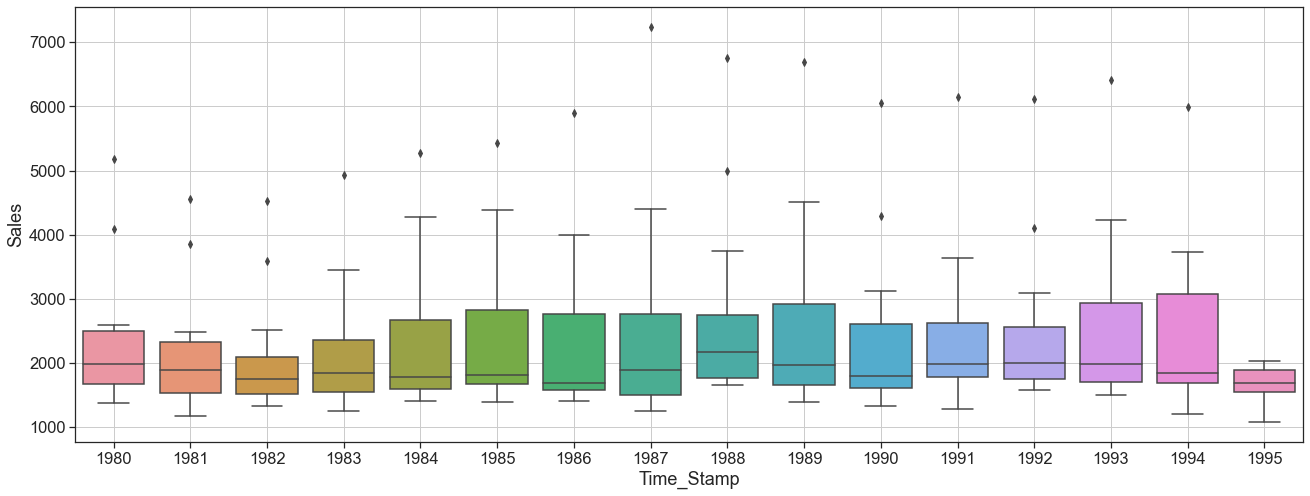

In [11]:
#Yearly Boxplot
fig,ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = spark.index.year,y = spark.values[:,0],ax=ax)
plt.ylabel("Sales")
plt.grid();

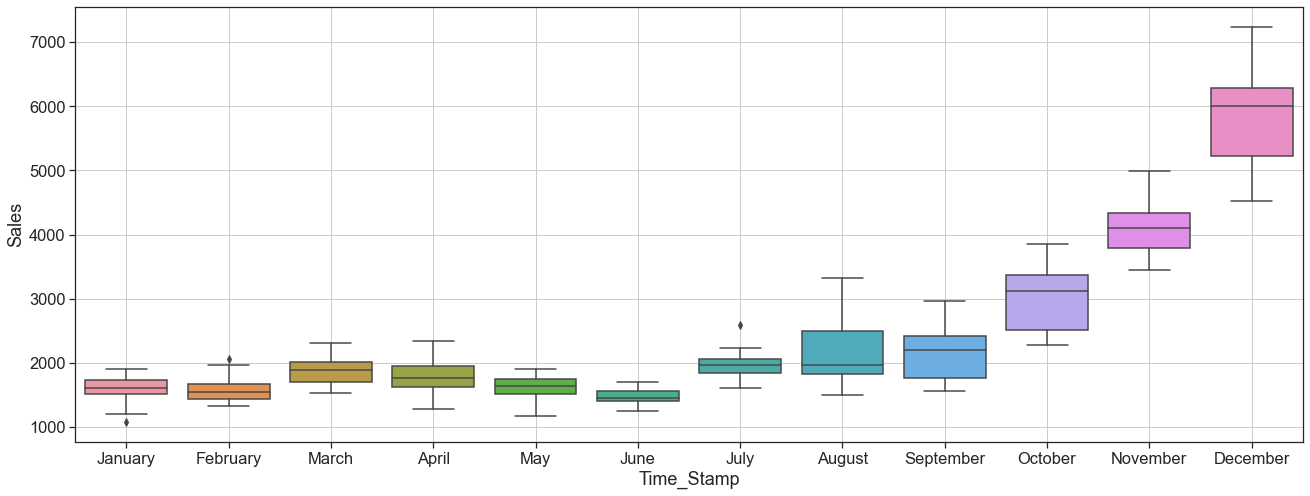

In [12]:
#Monthly Plot
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = spark.index.month_name(),y = spark.values[:,0],ax=ax)
plt.ylabel("Sales")
plt.grid();

In [13]:
#Monthly Sales 
monthly_sales_across_years = pd.pivot_table(spark, values = 'Sparkling', columns = spark.index.month_name(),
                                            index = spark.index.year)
monthly_sales_across_years

Time_Stamp   April  August  December  February  January    July    June  \
Time_Stamp                                                                
1980        1712.0  2453.0    5179.0    1591.0   1686.0  1966.0  1377.0   
1981        1976.0  2472.0    4551.0    1523.0   1530.0  1781.0  1480.0   
1982        1790.0  1897.0    4524.0    1329.0   1510.0  1954.0  1449.0   
1983        1375.0  2298.0    4923.0    1638.0   1609.0  1600.0  1245.0   
1984        1789.0  3159.0    5274.0    1435.0   1609.0  1597.0  1404.0   
1985        1589.0  2512.0    5434.0    1682.0   1771.0  1645.0  1379.0   
1986        1605.0  3318.0    5891.0    1523.0   1606.0  2584.0  1403.0   
1987        1935.0  1930.0    7242.0    1442.0   1389.0  1847.0  1250.0   
1988        2336.0  1645.0    6757.0    1779.0   1853.0  2230.0  1661.0   
1989        1650.0  1968.0    6694.0    1394.0   1757.0  1971.0  1406.0   
1990        1628.0  1605.0    6047.0    1321.0   1720.0  1899.0  1457.0   
1991        1279.0  1857.0    6153.0    2049.0   1902.0  2214.0  1540.0   
1992        1997.0  1773.0    6119.0    1667.0   1577.0  2076.0  1625.0   
1993        2121.0  2795.0    6410.0    1564.0   1494.0  2048.0  1515.0   
1994        1725.0  1495.0    5999.0    1968.0   1197.0  2031.0  1693.0   
1995        1862.0     NaN       NaN    1402.0   1070.0  2031.0  1688.0   

Time_Stamp   March     May  November  October  September  
Time_Stamp                                                
1980        2304.0  1471.0    4087.0   2596.0     1984.0  
1981        1633.0  1170.0    3857.0   2273.0     1981.0  
1982        1518.0  1537.0    3593.0   2514.0     1706.0  
1983        2030.0  1320.0    3440.0   2511.0     2191.0  
1984        2061.0  1567.0    4273.0   2504.0     1759.0  
1985        1846.0  1896.0    4388.0   3727.0     1771.0  
1986        1577.0  1765.0    3987.0   2349.0     1562.0  
1987        1548.0  1518.0    4405.0   3114.0     2638.0  
1988        2108.0  1728.0    4988.0   3740.0     2421.0  
1989        1982.0  1654.0    4514.0   3845.0     2608.0  
1990        1859.0  1615.0    4286.0   3116.0     2424.0  
1991        1874.0  1432.0    3627.0   3252.0     2408.0  
1992        1993.0  1783.0    4096.0   3088.0     2377.0  
1993        1898.0  1831.0    4227.0   3339.0     1749.0  
1994        1720.0  1674.0    3729.0   3385.0     2968.0  
1995        1897.0  1670.0       NaN      NaN        NaN

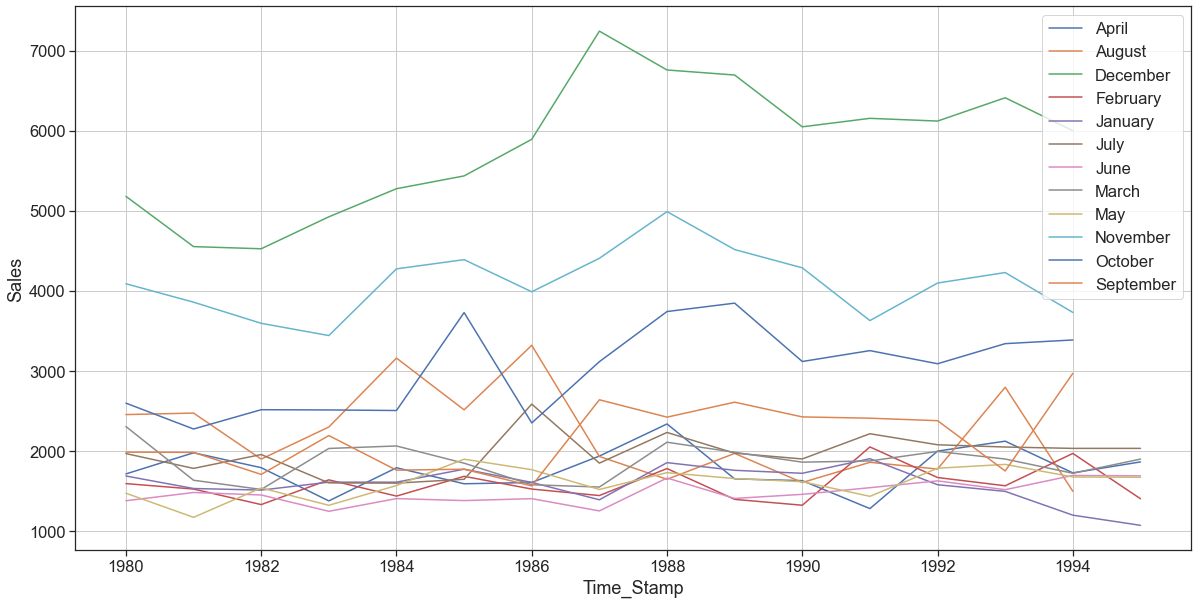

In [14]:
monthly_sales_across_years.plot(figsize=(20,10))
plt.grid()
plt.ylabel("Sales")
plt.legend(loc='best');

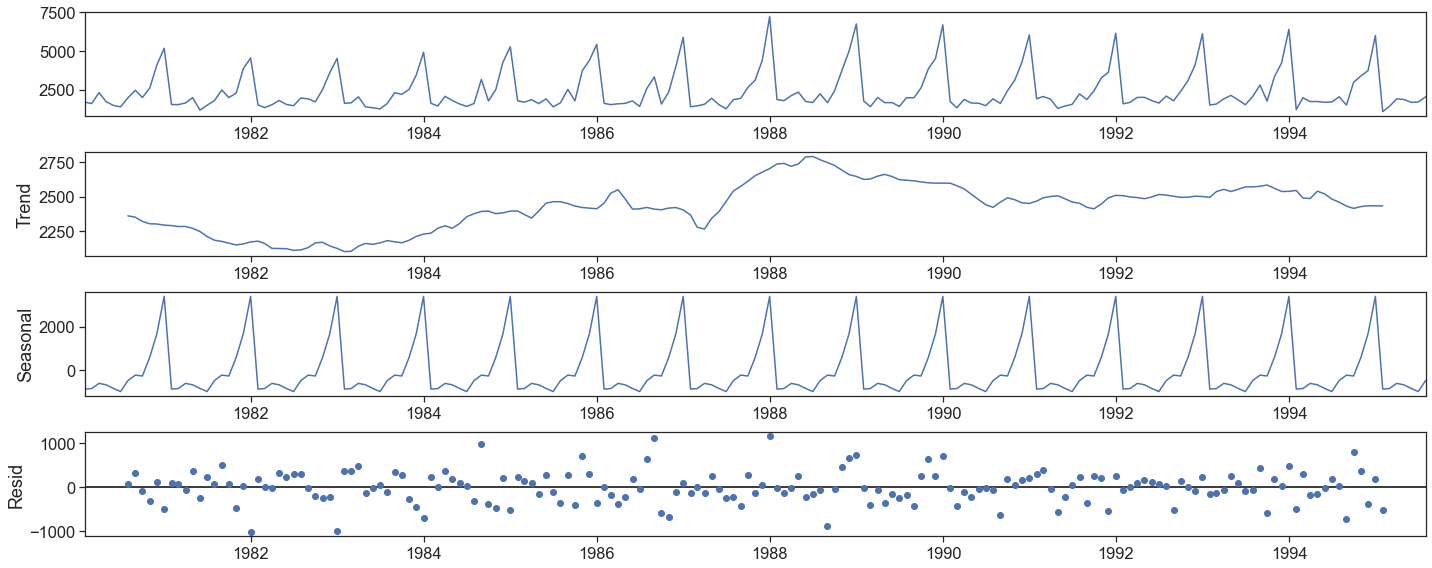

In [15]:
decomposition = seasonal_decompose(spark,model='additive')
rcParams['figure.figsize'] = 20,8
decomposition.plot();

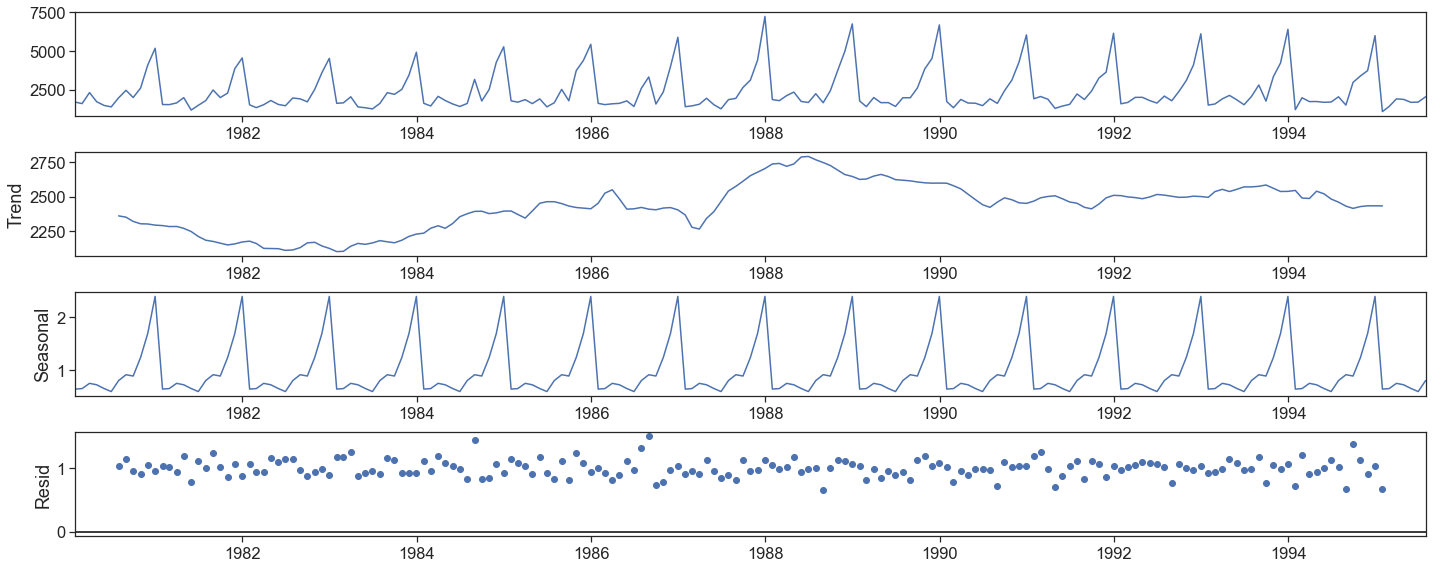

In [16]:
decomposition = seasonal_decompose(spark,model='multiplicative')
rcParams['figure.figsize'] = 20,8
decomposition.plot();

In [17]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

In [18]:
print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Time_Stamp
1980-01-31            NaN
1980-02-29            NaN
1980-03-31            NaN
1980-04-30            NaN
1980-05-31            NaN
1980-06-30            NaN
1980-07-31    2360.666667
1980-08-31    2351.333333
1980-09-30    2320.541667
1980-10-31    2303.583333
1980-11-30    2302.041667
1980-12-31    2293.791667
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-31    0.649843
1980-02-29    0.659214
1980-03-31    0.757440
1980-04-30    0.730351
1980-05-31    0.660609
1980-06-30    0.603468
1980-07-31    0.809164
1980-08-31    0.918822
1980-09-30    0.894367
1980-10-31    1.241789
1980-11-30    1.690158
1980-12-31    2.384776
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-31         NaN
1980-02-29         NaN
1980-03-31         NaN
1980-04-30         NaN
1980-05-31         NaN
1980-06-30         NaN
1980-07-31    1.029230
1980-08-31    1.135407
1980-09-30    0.955954
1980-10-31    0.907513
1980-11-30    1.050423
1980-12-31    0.946770
Name: r

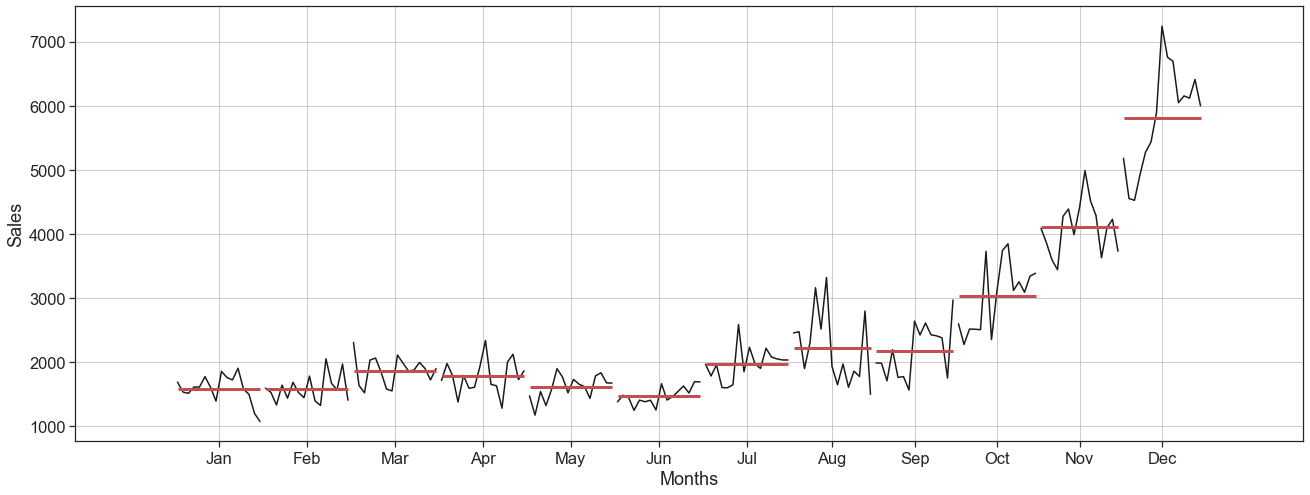

In [19]:
fig, ax = plt.subplots(figsize=(22,8))
month_plot(spark,ax=ax)
plt.ylabel("Sales")
plt.xlabel("Months")
plt.grid();

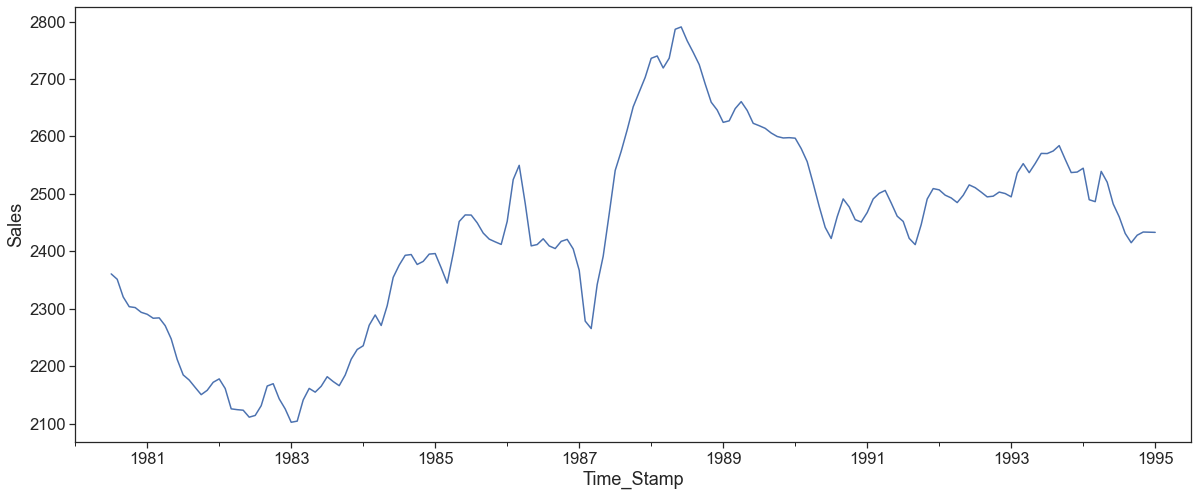

In [20]:
rcParams['figure.figsize'] = 20,8
plt.ylabel("Sales")
trend.plot();

In [21]:
#Split Data into training and test data
train=spark[spark.index.year < 1991]
test=spark[spark.index.year >= 1991]

In [22]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


In [23]:
print('First few rows of Training Data')
display(train.head())
print('Last few rows of Training Data')
display(train.tail())
print('First few rows of Test Data')
display(test.head())
print('Last few rows of Test Data')
display(test.tail())

First few rows of Training Data


Sparkling
Time_Stamp           
1980-01-31       1686
1980-02-29       1591
1980-03-31       2304
1980-04-30       1712
1980-05-31       1471

Last few rows of Training Data


Sparkling
Time_Stamp           
1990-08-31       1605
1990-09-30       2424
1990-10-31       3116
1990-11-30       4286
1990-12-31       6047

First few rows of Test Data


Sparkling
Time_Stamp           
1991-01-31       1902
1991-02-28       2049
1991-03-31       1874
1991-04-30       1279
1991-05-31       1432

Last few rows of Test Data


Sparkling
Time_Stamp           
1995-03-31       1897
1995-04-30       1862
1995-05-31       1670
1995-06-30       1688
1995-07-31       2031

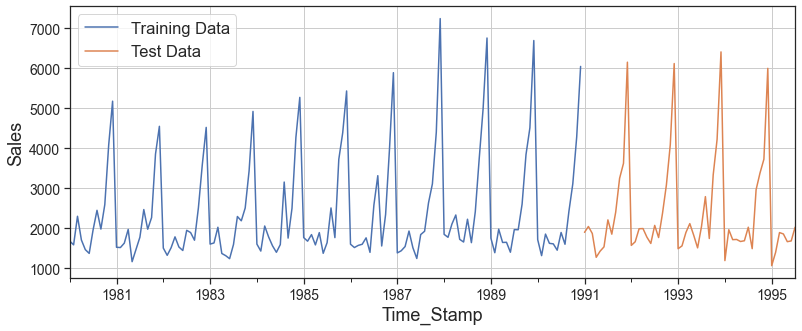

In [24]:
#Joint Plot of Train and Test Data
train['Sparkling'].plot(figsize=(13,5), fontsize=14)
test['Sparkling'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.ylabel("Sales")
plt.show()

In [25]:
# Model 1: Linear Regression
train_time = [i+1 for i in range(len(train))]
test_time = [i+133 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [26]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [27]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data','\n',LinearRegression_train.head(),'\n')
print('Last few rows of Training Data','\n',LinearRegression_train.tail(),'\n')
print('First few rows of Test Data','\n',LinearRegression_test.head(),'\n')
print('Last few rows of Test Data','\n',LinearRegression_test.tail(),'\n')

First few rows of Training Data 
             Sparkling  time
Time_Stamp                 
1980-01-31       1686     1
1980-02-29       1591     2
1980-03-31       2304     3
1980-04-30       1712     4
1980-05-31       1471     5 

Last few rows of Training Data 
             Sparkling  time
Time_Stamp                 
1990-08-31       1605   128
1990-09-30       2424   129
1990-10-31       3116   130
1990-11-30       4286   131
1990-12-31       6047   132 

First few rows of Test Data 
             Sparkling  time
Time_Stamp                 
1991-01-31       1902   133
1991-02-28       2049   134
1991-03-31       1874   135
1991-04-30       1279   136
1991-05-31       1432   137 

Last few rows of Test Data 
             Sparkling  time
Time_Stamp                 
1995-03-31       1897   183
1995-04-30       1862   184
1995-05-31       1670   185
1995-06-30       1688   186
1995-07-31       2031   187 



In [28]:
lr = LinearRegression()
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Sparkling'].values)

LinearRegression()

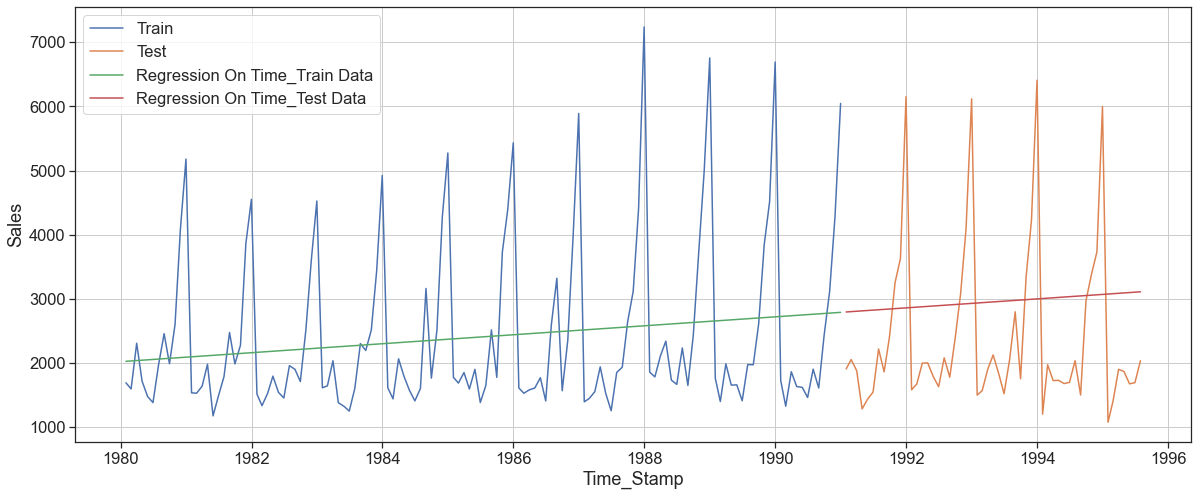

In [29]:
train_predictions_model1            = lr.predict(LinearRegression_train[['time']])
LinearRegression_train['RegOnTime'] = train_predictions_model1
test_predictions_model1             = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime']  = test_predictions_model1

plt.figure(figsize=(20,8))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(LinearRegression_train['RegOnTime'], label='Regression On Time_Train Data')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.grid();

In [30]:
#Model Evaluation
def MAPE(y, yhat):
    y, yhat = np.array(y),np.array(yhat)
    try:
        mape = round(np.sum(np.abs(yhat-y))/np.sum(y) * 100,2)
    except:
        print("Observed Values are empty")
        mape=np.nan
    return mape

In [31]:
import math
rmse = metrics.mean_squared_error(test['Sparkling'],test_predictions_model1)
math.sqrt(rmse)

1389.135174897992

In [32]:
## Train Data - RMSE and MAPE
rmse_model1_train = metrics.mean_squared_error(train['Sparkling'],train_predictions_model1,squared=False)
mape_model1_train = MAPE(train['Sparkling'],train_predictions_model1)
mape_model1_train

40.05

In [33]:
## Test Data - RMSE
rmse_model1_test = metrics.mean_squared_error(test['Sparkling'],test_predictions_model1,squared=False)
mape_model1_test = MAPE(test['Sparkling'],test_predictions_model1)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model1_test))
print("For RegressionOnTime forecast on the Test Data,  MAPE is %3.3f" %(mape_model1_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 1389.135
For RegressionOnTime forecast on the Test Data,  MAPE is 50.150


In [34]:
results = pd.DataFrame({'Train RMSE': [rmse_model1_train],'Test RMSE': [rmse_model1_test],
                        'Train MAPE': [mape_model1_train],'Test MAPE': [mape_model1_test]},
                       index=['RegressionOnTime'])
results

Train RMSE    Test RMSE  Train MAPE  Test MAPE
RegressionOnTime  1279.322346  1389.135175       40.05      50.15

In [35]:
#Model 2: Naive Approach
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [36]:
NaiveModel_train['naive'] = np.asarray(train['Sparkling'])[len(np.asarray(train['Sparkling']))-1]
display(NaiveModel_train['naive'].head())
NaiveModel_test['naive'] = np.asarray(test['Sparkling'])[len(np.asarray(test['Sparkling']))-1]
display(NaiveModel_test['naive'].head())

Time_Stamp
1980-01-31    6047
1980-02-29    6047
1980-03-31    6047
1980-04-30    6047
1980-05-31    6047
Name: naive, dtype: int64

Time_Stamp
1991-01-31    2031
1991-02-28    2031
1991-03-31    2031
1991-04-30    2031
1991-05-31    2031
Name: naive, dtype: int64

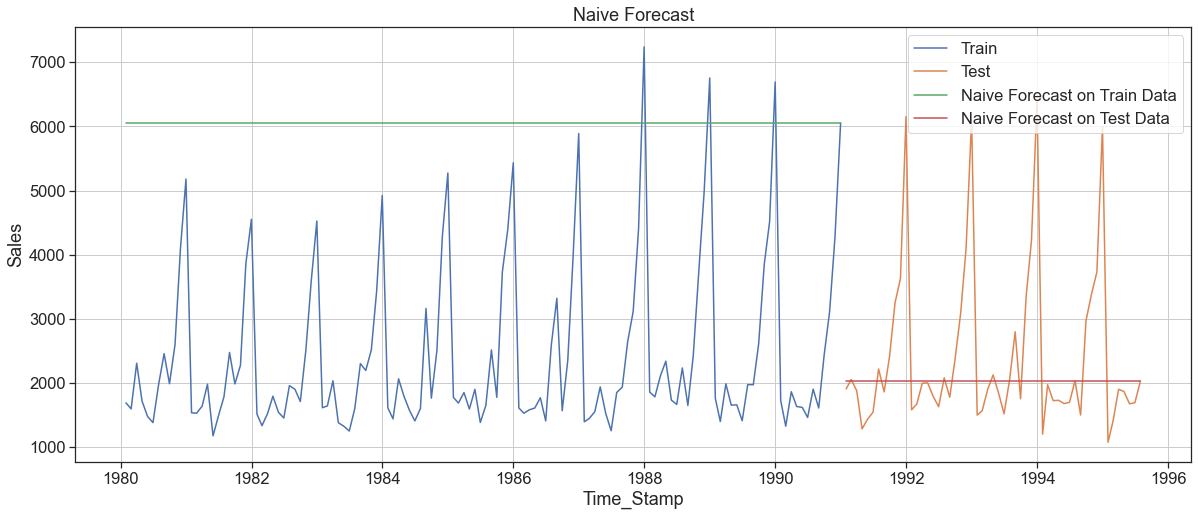

In [37]:
plt.figure(figsize=(20,8))
plt.plot(NaiveModel_train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(NaiveModel_train['naive'], label='Naive Forecast on Train Data')
plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.grid();

In [38]:
## Train Data - RMSE and MAPE

rmse_model2_train = metrics.mean_squared_error(train['Sparkling'],NaiveModel_train['naive'],squared=False)
mape_model2_train = MAPE(train['Sparkling'],NaiveModel_train['naive'])
rmse_model2_train, mape_model2_train

(3867.700801823254, 153.17)

In [39]:
## Test Data - RMSE and MAPE

rmse_model2_test = metrics.mean_squared_error(test['Sparkling'],NaiveModel_test['naive'],squared=False)
mape_model2_test = MAPE(test['Sparkling'],NaiveModel_test['naive'])
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model2_test))
print("For RegressionOnTime forecast on the Test Data,  MAPE is %3.3f" %(mape_model2_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 1327.156
For RegressionOnTime forecast on the Test Data,  MAPE is 32.900


In [40]:
resultsDf_2 = pd.DataFrame({'Train RMSE': [rmse_model2_train],'Test RMSE': [rmse_model2_test],
                            'Train MAPE': [mape_model2_train],'Test MAPE': [mape_model2_test]}
                           ,index=['NaiveModel'])

results = pd.concat([results, resultsDf_2])
results

Train RMSE    Test RMSE  Train MAPE  Test MAPE
RegressionOnTime  1279.322346  1389.135175       40.05      50.15
NaiveModel        3867.700802  1327.156057      153.17      32.90

In [41]:
#Simple Average
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [42]:
SimpleAverage_train['mean_forecast'] = train['Sparkling'].mean()
display(SimpleAverage_train.head())
SimpleAverage_test['mean_forecast'] = train['Sparkling'].mean()
display(SimpleAverage_test.head())

Sparkling  mean_forecast
Time_Stamp                          
1980-01-31       1686    2403.780303
1980-02-29       1591    2403.780303
1980-03-31       2304    2403.780303
1980-04-30       1712    2403.780303
1980-05-31       1471    2403.780303

Sparkling  mean_forecast
Time_Stamp                          
1991-01-31       1902    2403.780303
1991-02-28       2049    2403.780303
1991-03-31       1874    2403.780303
1991-04-30       1279    2403.780303
1991-05-31       1432    2403.780303

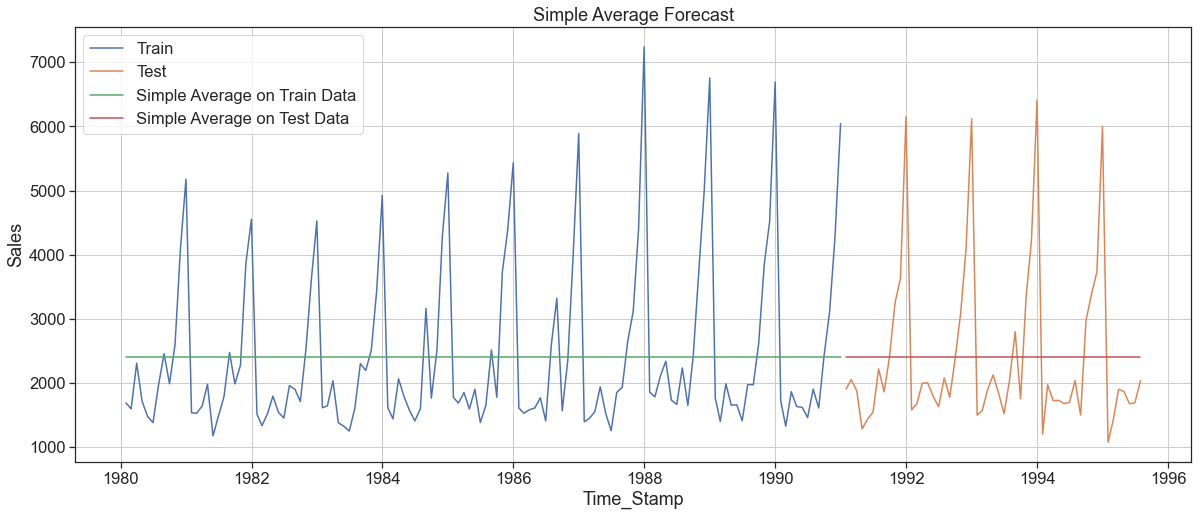

In [43]:
plt.figure(figsize=(20,8))
plt.plot(SimpleAverage_train['Sparkling'], label='Train')
plt.plot(SimpleAverage_test['Sparkling'], label='Test')
plt.plot(SimpleAverage_train['mean_forecast'], label='Simple Average on Train Data')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.grid();

In [44]:
## Train and Test Data - RMSE  and MAPE

rmse_model3_train = metrics.mean_squared_error(train['Sparkling'],SimpleAverage_train['mean_forecast'],squared=False)
mape_model3_train = MAPE(train['Sparkling'],SimpleAverage_train['mean_forecast'])
rmse_model3_test = metrics.mean_squared_error(test['Sparkling'],SimpleAverage_test['mean_forecast'],squared=False)
mape_model3_test = MAPE(test['Sparkling'],SimpleAverage_test['mean_forecast'])

In [45]:
resultsDf_3 = pd.DataFrame({'Train RMSE': [rmse_model3_train],'Test RMSE': [rmse_model3_test],
                            'Train MAPE': [mape_model3_train],'Test MAPE': [mape_model3_test]}
                           ,index=['SimpleAverageModel'])

results = pd.concat([results, resultsDf_3])
results

Train RMSE    Test RMSE  Train MAPE  Test MAPE
RegressionOnTime    1279.322346  1389.135175       40.05      50.15
NaiveModel          3867.700802  1327.156057      153.17      32.90
SimpleAverageModel  1298.483628  1275.081804       40.36      38.90

In [46]:
#Moving Average
MovingAverage = spark.copy()
MovingAverage.head()

Sparkling
Time_Stamp           
1980-01-31       1686
1980-02-29       1591
1980-03-31       2304
1980-04-30       1712
1980-05-31       1471

In [47]:
MovingAverage['Trailing_2'] = MovingAverage['Sparkling'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Sparkling'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Sparkling'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Sparkling'].rolling(9).mean()
MovingAverage.head(10)

Sparkling  Trailing_2  Trailing_4   Trailing_6   Trailing_9
Time_Stamp                                                             
1980-01-31       1686         NaN         NaN          NaN          NaN
1980-02-29       1591      1638.5         NaN          NaN          NaN
1980-03-31       2304      1947.5         NaN          NaN          NaN
1980-04-30       1712      2008.0     1823.25          NaN          NaN
1980-05-31       1471      1591.5     1769.50          NaN          NaN
1980-06-30       1377      1424.0     1716.00  1690.166667          NaN
1980-07-31       1966      1671.5     1631.50  1736.833333          NaN
1980-08-31       2453      2209.5     1816.75  1880.500000          NaN
1980-09-30       1984      2218.5     1945.00  1827.166667  1838.222222
1980-10-31       2596      2290.0     2249.75  1974.500000  1939.333333

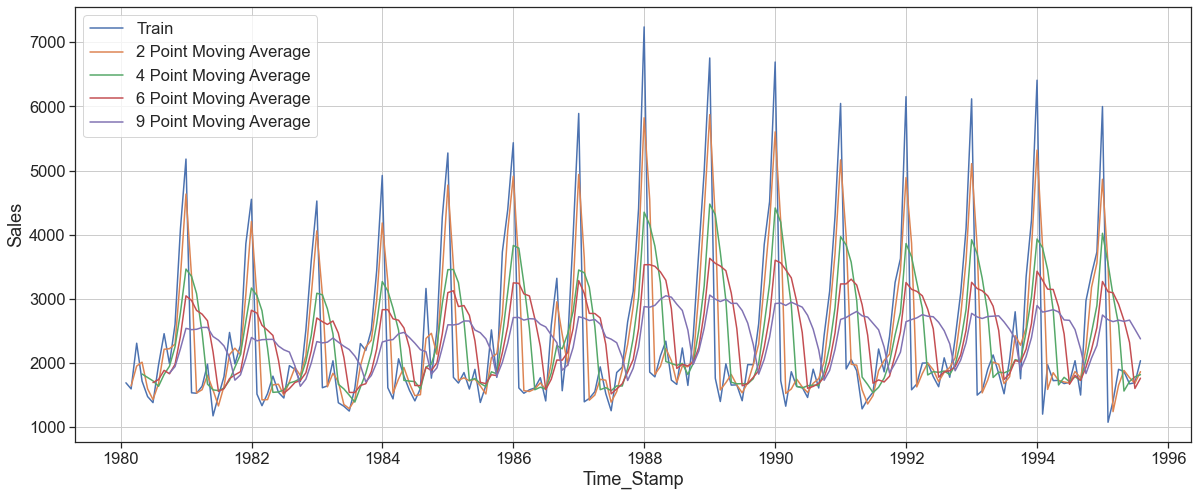

In [48]:
plt.figure(figsize=(20,8))
plt.plot(MovingAverage['Sparkling'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'], label='6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'], label='9 Point Moving Average')

plt.legend(loc = 'best')
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.grid();

In [49]:
trailing_MovingAverage_train=MovingAverage[MovingAverage.index.year < 1991]
trailing_MovingAverage_test=MovingAverage[MovingAverage.index.year >= 1991]

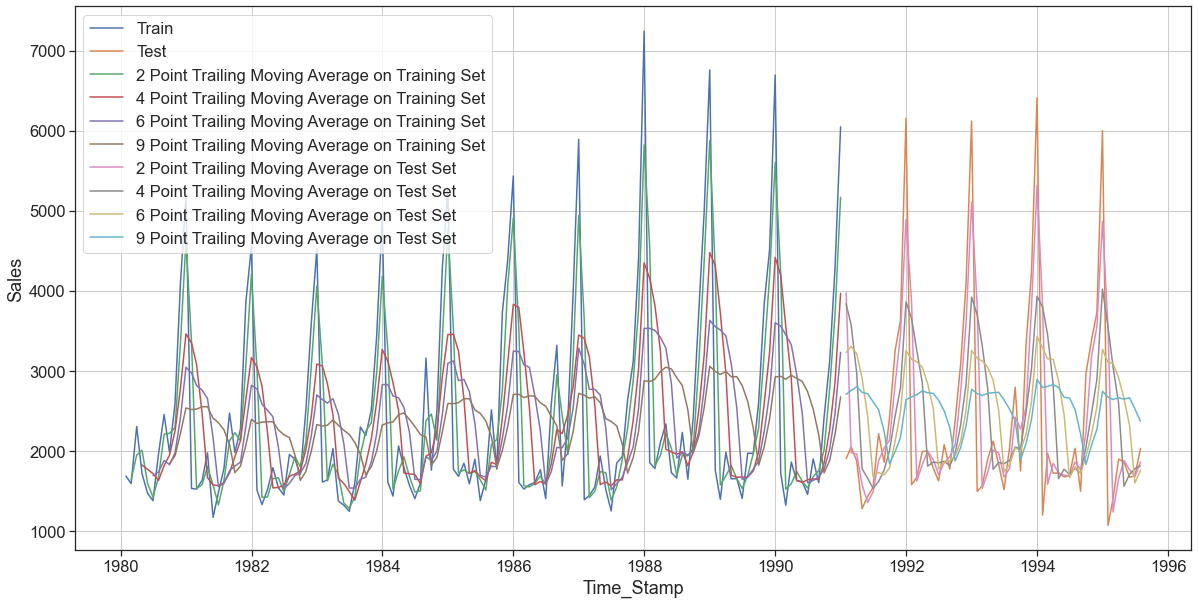

In [50]:
plt.figure(figsize=(20,10))
plt.plot(trailing_MovingAverage_train['Sparkling'], label='Train')
plt.plot(trailing_MovingAverage_test['Sparkling'], label='Test')

plt.plot(trailing_MovingAverage_train['Trailing_2'], label = '2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_4'], label = '4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'], label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'], label = '9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label = '2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label = '4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'], label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'], label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.grid();

In [51]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model4_test_2 = metrics.mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_2'],squared=False)
mape_model4_test_2 = MAPE(test['Sparkling'],trailing_MovingAverage_test['Trailing_2'])
print("For 2 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f" %(rmse_model4_test_2))
print("For 2 point Moving Average Model forecast on the Testing Data,  MAPE is %3.3f" %(mape_model4_test_2))

## Test Data - RMSE  --> 4 point Trailing MA


rmse_model4_test_4 = metrics.mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_4'],squared=False)
mape_model4_test_4 = MAPE(test['Sparkling'],trailing_MovingAverage_test['Trailing_4'])
print("For 4 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f" %(rmse_model4_test_4))
print("For 4 point Moving Average Model forecast on the Testing Data,  MAPE is %3.3f" %(mape_model4_test_4))

## Test Data - RMSE --> 6 point Trailing MA


rmse_model4_test_6 = metrics.mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_6'],squared=False)
mape_model4_test_6 = MAPE(test['Sparkling'],trailing_MovingAverage_test['Trailing_6'])
print("For 6 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f" %(rmse_model4_test_6))
print("For 6 point Moving Average Model forecast on the Testing Data,  MAPE is %3.3f" %(mape_model4_test_6))

## Test Data - RMSE  --> 9 point Trailing MA


rmse_model4_test_9 = metrics.mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_9'],squared=False)
mape_model4_test_9 = MAPE(test['Sparkling'],trailing_MovingAverage_test['Trailing_9'])
print("For 9 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f " %(rmse_model4_test_9))
print("For 9 point Moving Average Model forecast on the Testing Data,  MAPE is %3.3f" %(mape_model4_test_9))

For 2 point Moving Average Model forecast on the Testing Data,  RMSE is 813.401
For 2 point Moving Average Model forecast on the Testing Data,  MAPE is 19.700
For 4 point Moving Average Model forecast on the Testing Data,  RMSE is 1156.590
For 4 point Moving Average Model forecast on the Testing Data,  MAPE is 35.960
For 6 point Moving Average Model forecast on the Testing Data,  RMSE is 1283.927
For 6 point Moving Average Model forecast on the Testing Data,  MAPE is 43.860
For 9 point Moving Average Model forecast on the Testing Data,  RMSE is 1346.278 
For 9 point Moving Average Model forecast on the Testing Data,  MAPE is 46.860


In [52]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_4
                                          ,rmse_model4_test_6,rmse_model4_test_9],
                            'Test MAPE': [mape_model4_test_2,mape_model4_test_4
                                          ,mape_model4_test_6,mape_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

results = pd.concat([results, resultsDf_4])
results

Train RMSE    Test RMSE  Train MAPE  Test MAPE
RegressionOnTime             1279.322346  1389.135175       40.05      50.15
NaiveModel                   3867.700802  1327.156057      153.17      32.90
SimpleAverageModel           1298.483628  1275.081804       40.36      38.90
2pointTrailingMovingAverage          NaN   813.400684         NaN      19.70
4pointTrailingMovingAverage          NaN  1156.589694         NaN      35.96
6pointTrailingMovingAverage          NaN  1283.927428         NaN      43.86
9pointTrailingMovingAverage          NaN  1346.278315         NaN      46.86

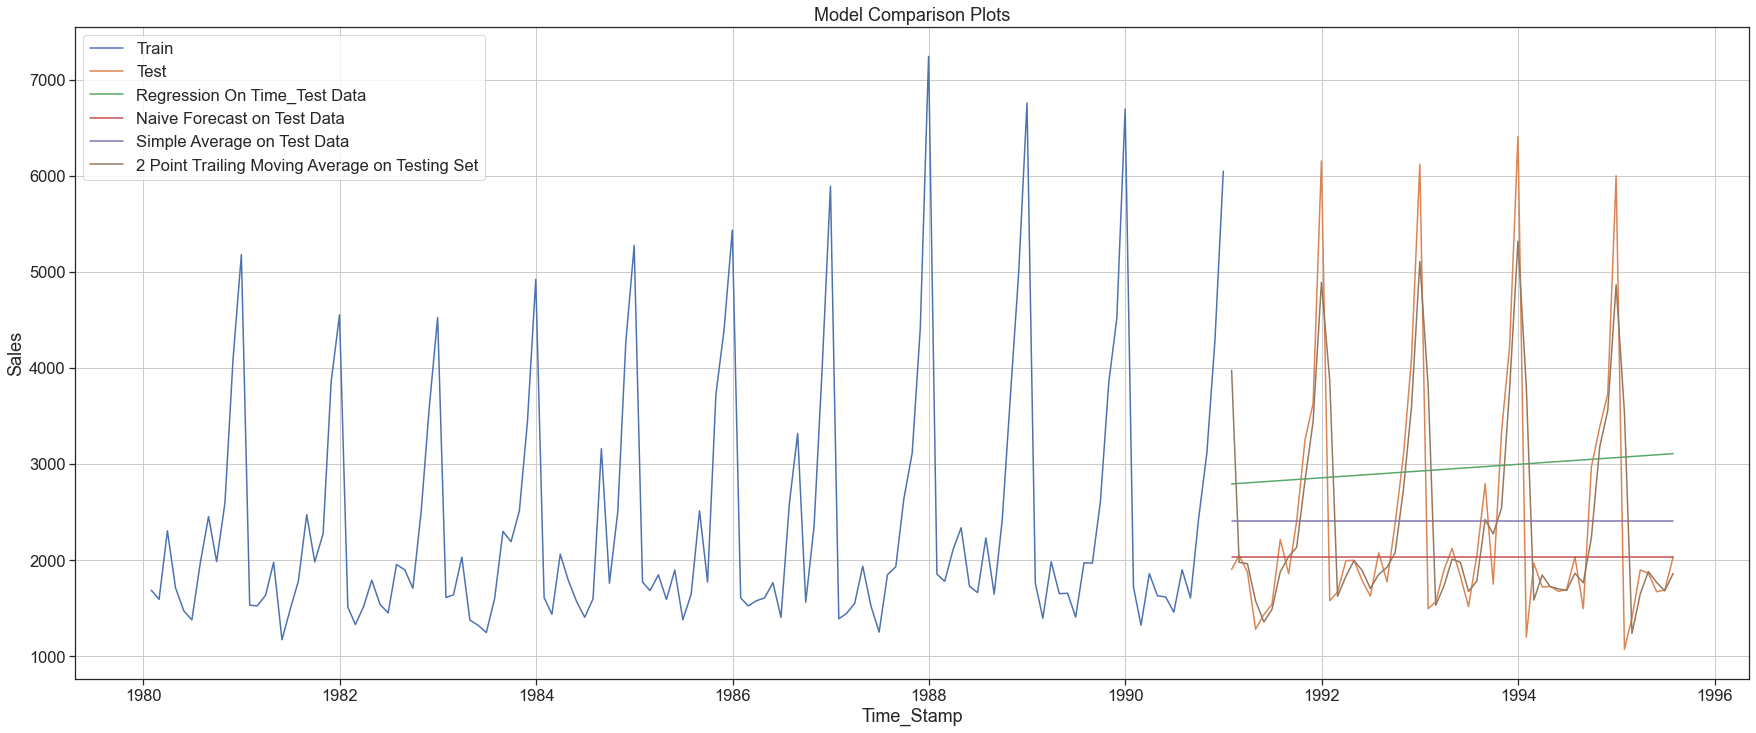

In [53]:
## Plotting on both Training and Test data

plt.figure(figsize=(30,12))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')

plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')

plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')

plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Testing Set')

plt.legend(loc='best')
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.title("Model Comparison Plots")
plt.grid();

In [54]:
#Simple Exponential Smoothing
SES_train = train.copy()
SES_test = test.copy()

In [55]:
model_SES = SimpleExpSmoothing(SES_train['Sparkling'])

In [56]:
model_SES_autofit = model_SES.fit(optimized=True)
model_SES_autofit.params

{'smoothing_level': 0.04960659884563118,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1818.5047543457245,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [57]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

Sparkling      predict
Time_Stamp                        
1991-01-31       1902  2724.929339
1991-02-28       2049  2724.929339
1991-03-31       1874  2724.929339
1991-04-30       1279  2724.929339
1991-05-31       1432  2724.929339

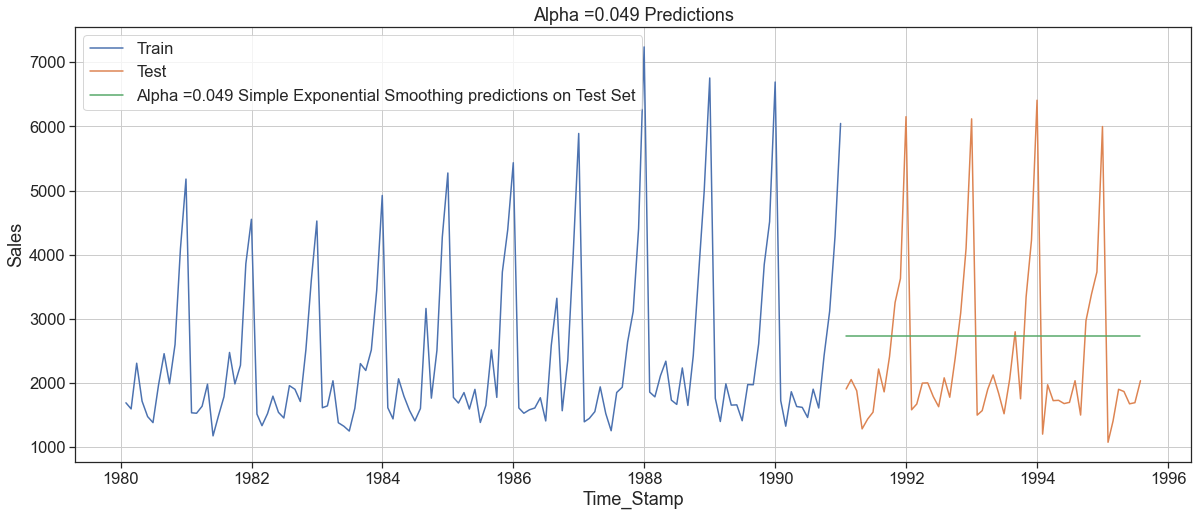

In [58]:
plt.figure(figsize=(20,8))
plt.plot(SES_train['Sparkling'], label='Train')
plt.plot(SES_test['Sparkling'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =0.049 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.title('Alpha =0.049 Predictions');

In [59]:
rmse_model5_test_1 = metrics.mean_squared_error(SES_test['Sparkling'],SES_test['predict'],squared=False)
mape_model5_test_1 = MAPE(SES_test['Sparkling'],SES_test['predict'])
print("For Alpha =0.049 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model5_test_1))
print("For Alpha =0.049 Simple Exponential Smoothing Model forecast on the Test Data, MAPE is %3.3f" %(mape_model5_test_1))

For Alpha =0.049 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is 1316.035
For Alpha =0.049 Simple Exponential Smoothing Model forecast on the Test Data, MAPE is 45.470


In [60]:
resultsDf_5 = pd.DataFrame({'Test RMSE': [rmse_model5_test_1],'Test MAPE': [mape_model5_test_1]},
                           index=['Alpha=0.049,SimpleExponentialSmoothing'])

results = pd.concat([results, resultsDf_5])
results['Test RMSE']

RegressionOnTime                          1389.135175
NaiveModel                                1327.156057
SimpleAverageModel                        1275.081804
2pointTrailingMovingAverage                813.400684
4pointTrailingMovingAverage               1156.589694
6pointTrailingMovingAverage               1283.927428
9pointTrailingMovingAverage               1346.278315
Alpha=0.049,SimpleExponentialSmoothing    1316.034674
Name: Test RMSE, dtype: float64

In [61]:
resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Train MAPE':[],'Test RMSE': [],'Test MAPE': []})
for i in np.arange(0.1,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=55)
    
    rmse_model5_train_i = metrics.mean_squared_error(SES_train['Sparkling'],SES_train['predict',i],squared=False)
    mape_model5_train_i = MAPE(SES_train['Sparkling'],SES_train['predict',i])
    
    rmse_model5_test_i = metrics.mean_squared_error(SES_test['Sparkling'],SES_test['predict',i],squared=False)
    mape_model5_test_i = MAPE(SES_test['Sparkling'],SES_test['predict',i])
    
    resultsDf_6 = resultsDf_6.append({'Alpha Values':i,'Train RMSE':rmse_model5_train_i 
                                      ,'Train MAPE':mape_model5_train_i
                                      ,'Test RMSE':rmse_model5_test_i
                                      ,'Test MAPE':mape_model5_test_i }, ignore_index=True)

In [62]:
resultsDf_6.sort_values(by=['Test RMSE'])

Alpha Values   Train RMSE  Train MAPE    Test RMSE  Test MAPE
0           0.1  1333.873836       42.03  1375.393398      49.53
1           0.2  1356.042987       43.79  1595.206839      60.46
2           0.3  1359.511747       43.73  1935.507132      75.66
3           0.4  1352.588879       42.75  2311.919615      91.55
4           0.5  1344.004369       41.16  2666.351413     106.27
5           0.6  1338.805381       39.80  2979.204388     118.77
6           0.7  1338.844308       38.55  3249.944092     129.34
7           0.8  1344.462091       37.60  3483.801006     138.34
8           0.9  1355.723518       36.79  3686.794285     146.08

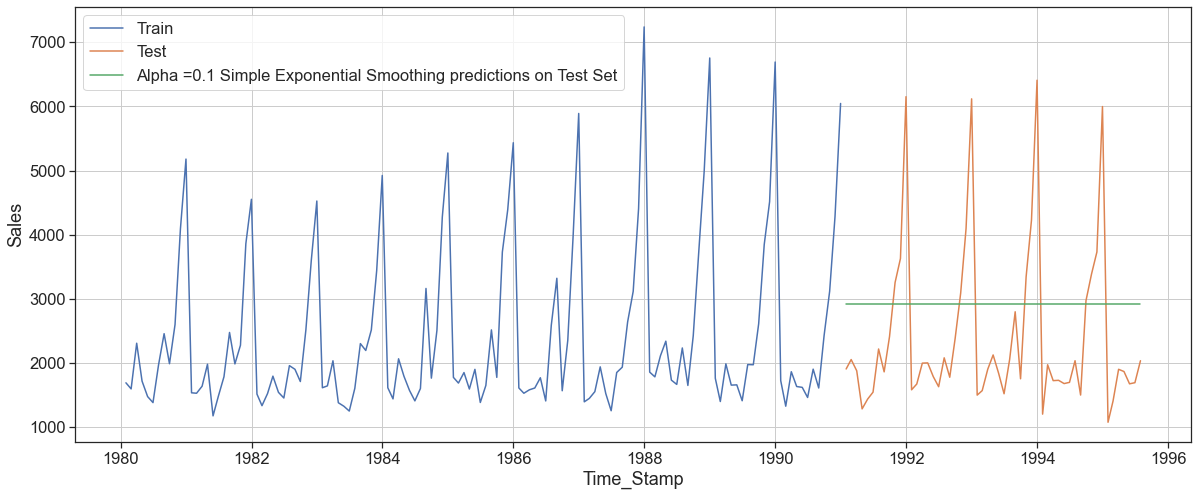

In [63]:
plt.figure(figsize=(20,8))
plt.plot(SES_train['Sparkling'], label='Train')
plt.plot(SES_test['Sparkling'], label='Test')

plt.plot(SES_test['predict', 0.1], label='Alpha =0.1 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.grid();

In [64]:
resultsDf_6_1 = pd.DataFrame({'Train RMSE': [resultsDf_6['Train RMSE'][0]],
                              'Test RMSE': [resultsDf_6['Test RMSE'][0]],
                              'Train MAPE': [resultsDf_6['Train MAPE'][0]],
                              'Test MAPE': [resultsDf_6['Test MAPE'][0]]}
                           ,index=['Alpha=0.1,SimpleExponentialSmoothing'])

results = pd.concat([results, resultsDf_6_1])
results

Train RMSE    Test RMSE  Train MAPE  \
RegressionOnTime                        1279.322346  1389.135175       40.05   
NaiveModel                              3867.700802  1327.156057      153.17   
SimpleAverageModel                      1298.483628  1275.081804       40.36   
2pointTrailingMovingAverage                     NaN   813.400684         NaN   
4pointTrailingMovingAverage                     NaN  1156.589694         NaN   
6pointTrailingMovingAverage                     NaN  1283.927428         NaN   
9pointTrailingMovingAverage                     NaN  1346.278315         NaN   
Alpha=0.049,SimpleExponentialSmoothing          NaN  1316.034674         NaN   
Alpha=0.1,SimpleExponentialSmoothing    1333.873836  1375.393398       42.03   

                                        Test MAPE  
RegressionOnTime                            50.15  
NaiveModel                                  32.90  
SimpleAverageModel                          38.90  
2pointTrailingMovingAverage                 19.70  
4pointTrailingMovingAverage                 35.96  
6pointTrailingMovingAverage                 43.86  
9pointTrailingMovingAverage                 46.86  
Alpha=0.049,SimpleExponentialSmoothing      45.47  
Alpha=0.1,SimpleExponentialSmoothing        49.53

In [65]:
#Double Exponential Smoothing
DES_train = train.copy()
DES_test = test.copy()

In [66]:
model_DES = Holt(DES_train['Sparkling'])

In [67]:
model_DES_autofit = model_DES.fit(optimized=True)
model_DES_autofit.params

{'smoothing_level': 0.6885714285714285,
 'smoothing_trend': 9.999999999999999e-05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1686.0,
 'initial_trend': -95.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [68]:
DES_test['predict'] = model_DES_autofit.forecast(steps=len(test))
DES_test.head()

Sparkling      predict
Time_Stamp                        
1991-01-31       1902  5221.278699
1991-02-28       2049  5127.886554
1991-03-31       1874  5034.494409
1991-04-30       1279  4941.102264
1991-05-31       1432  4847.710119

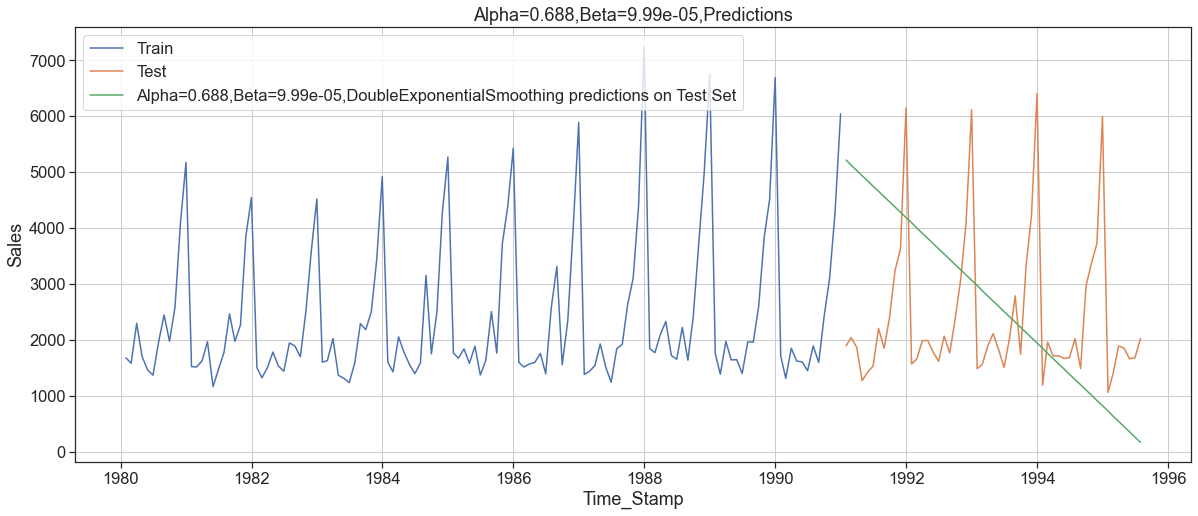

In [69]:
plt.figure(figsize=(20,8))
plt.plot(DES_train['Sparkling'], label='Train')
plt.plot(DES_test['Sparkling'], label='Test')

plt.plot(DES_test['predict'], label='Alpha=0.688,Beta=9.99e-05,DoubleExponentialSmoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.title('Alpha=0.688,Beta=9.99e-05,Predictions');

In [70]:
resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': [],'Train MAPE':[],
                            'Test MAPE':[]})
for i in np.arange(0.1,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=55)
        
        rmse_model6_train = metrics.mean_squared_error(DES_train['Sparkling'],DES_train['predict',i,j],squared=False)
        mape_model6_train = MAPE(DES_train['Sparkling'],DES_train['predict',i,j])
        
        rmse_model6_test = metrics.mean_squared_error(DES_test['Sparkling'],DES_test['predict',i,j],squared=False)
        mape_model6_test = MAPE(DES_test['Sparkling'],DES_test['predict',i,j])
        resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,
                                          'Train RMSE':rmse_model6_train,
                                          'Test RMSE':rmse_model6_test,
                                          'Train MAPE':mape_model6_train,
                                          'Test MAPE':mape_model6_test}, ignore_index=True)

In [71]:
display(resultsDf_7.sort_values(by=['Train RMSE']).head())
display(resultsDf_7.sort_values(by=['Test RMSE']).head())

Alpha Values  Beta Values   Train RMSE     Test RMSE  Train MAPE  \
0            0.1          0.1  1382.520870   1778.564670       44.37   
60           0.7          0.1  1399.271428  12268.287993       39.56   
50           0.6          0.1  1401.617101  11169.194054       41.15   
70           0.8          0.1  1404.526096  13161.387647       38.52   
40           0.5          0.1  1411.152907   9788.112870       43.23   

    Test MAPE  
0       67.20  
60     470.43  
50     427.73  
70     505.13  
40     374.03

Alpha Values  Beta Values   Train RMSE    Test RMSE  Train MAPE  Test MAPE
0            0.1          0.1  1382.520870  1778.564670       44.37      67.20
1            0.1          0.2  1413.598835  2599.439986       46.14      95.43
10           0.2          0.1  1418.041591  3611.763322       46.65     135.41
2            0.1          0.3  1445.762015  4293.084674       47.43     155.43
20           0.3          0.1  1431.169601  5908.185554       46.99     223.50

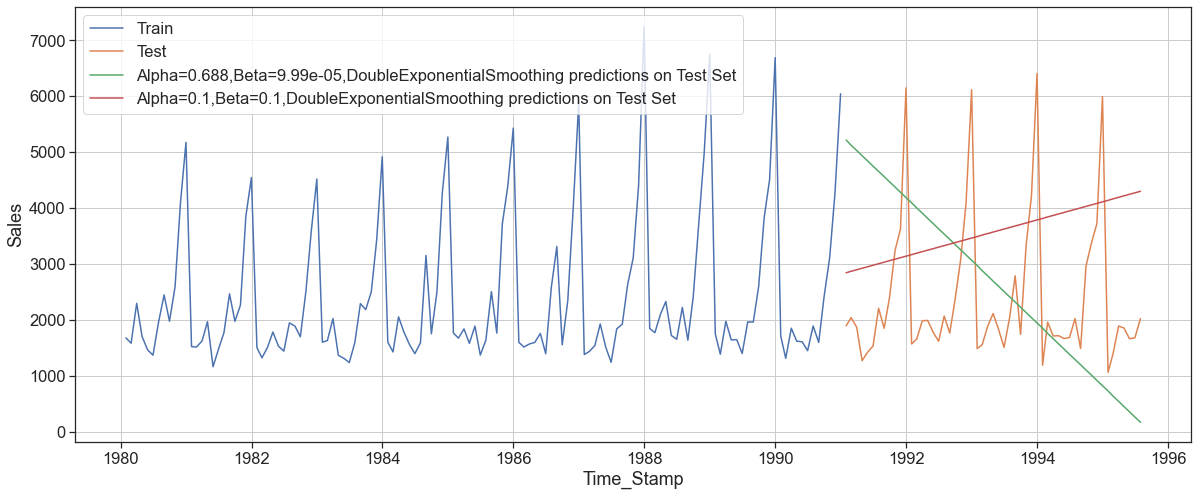

In [72]:
plt.figure(figsize=(20,8))
plt.plot(DES_train['Sparkling'], label='Train')
plt.plot(DES_test['Sparkling'], label='Test')
plt.plot(DES_test['predict'], label='Alpha=0.688,Beta=9.99e-05,DoubleExponentialSmoothing predictions on Test Set')
plt.plot(DES_test['predict', 0.1, 0.1], label='Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing predictions on Test Set')
plt.xlabel("Time_Stamp")
plt.ylabel("Sales")
plt.legend(loc='best')
plt.grid();

In [73]:
resultsDf_7_1 = pd.DataFrame({'Train RMSE': [resultsDf_7['Train RMSE'][0]],
                              'Test RMSE': [resultsDf_7['Test RMSE'][0]],
                              'Train MAPE': [resultsDf_7['Train MAPE'][0]],
                              'Test MAPE': [resultsDf_7['Test MAPE'][0]]}
                           ,index=['Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing'])

results = pd.concat([results, resultsDf_7_1])
results

Train RMSE    Test RMSE  \
RegressionOnTime                               1279.322346  1389.135175   
NaiveModel                                     3867.700802  1327.156057   
SimpleAverageModel                             1298.483628  1275.081804   
2pointTrailingMovingAverage                            NaN   813.400684   
4pointTrailingMovingAverage                            NaN  1156.589694   
6pointTrailingMovingAverage                            NaN  1283.927428   
9pointTrailingMovingAverage                            NaN  1346.278315   
Alpha=0.049,SimpleExponentialSmoothing                 NaN  1316.034674   
Alpha=0.1,SimpleExponentialSmoothing           1333.873836  1375.393398   
Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing  1382.520870  1778.564670   

                                               Train MAPE  Test MAPE  
RegressionOnTime                                    40.05      50.15  
NaiveModel                                         153.17      32.90  
SimpleAverageModel                                  40.36      38.90  
2pointTrailingMovingAverage                           NaN      19.70  
4pointTrailingMovingAverage                           NaN      35.96  
6pointTrailingMovingAverage                           NaN      43.86  
9pointTrailingMovingAverage                           NaN      46.86  
Alpha=0.049,SimpleExponentialSmoothing                NaN      45.47  
Alpha=0.1,SimpleExponentialSmoothing                42.03      49.53  
Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing       44.37      67.20

In [74]:
#Triple Exponential Smoothing (Holt - Winter's Model)
TES_train = train.copy()
TES_test = test.copy()

In [75]:
model_TES = ExponentialSmoothing(TES_train['Sparkling'],trend='additive',seasonal='additive',freq='M')

In [76]:
model_TES_autofit = model_TES.fit()
model_TES_autofit.params

{'smoothing_level': 0.10005373820823961,
 'smoothing_trend': 0.010034490652580457,
 'smoothing_seasonal': 0.5095957543425532,
 'damping_trend': nan,
 'initial_level': 2364.584774604334,
 'initial_trend': -0.016752880078245408,
 'initial_seasons': array([-653.82559323, -736.67734144, -368.25456128, -483.63906084,
        -826.15467946, -832.96819741, -386.3751117 ,   91.82676187,
        -261.32455153,  265.38968222, 1580.26233564, 2619.56221896]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [77]:
TES_train['auto_predict'] = model_TES_autofit.fittedvalues
display(TES_test.head())
TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))
display(TES_test.head())

Sparkling
Time_Stamp           
1991-01-31       1902
1991-02-28       2049
1991-03-31       1874
1991-04-30       1279
1991-05-31       1432

Sparkling  auto_predict
Time_Stamp                         
1991-01-31       1902   1509.969093
1991-02-28       2049   1205.343244
1991-03-31       1874   1702.386113
1991-04-30       1279   1548.514691
1991-05-31       1432   1467.824074

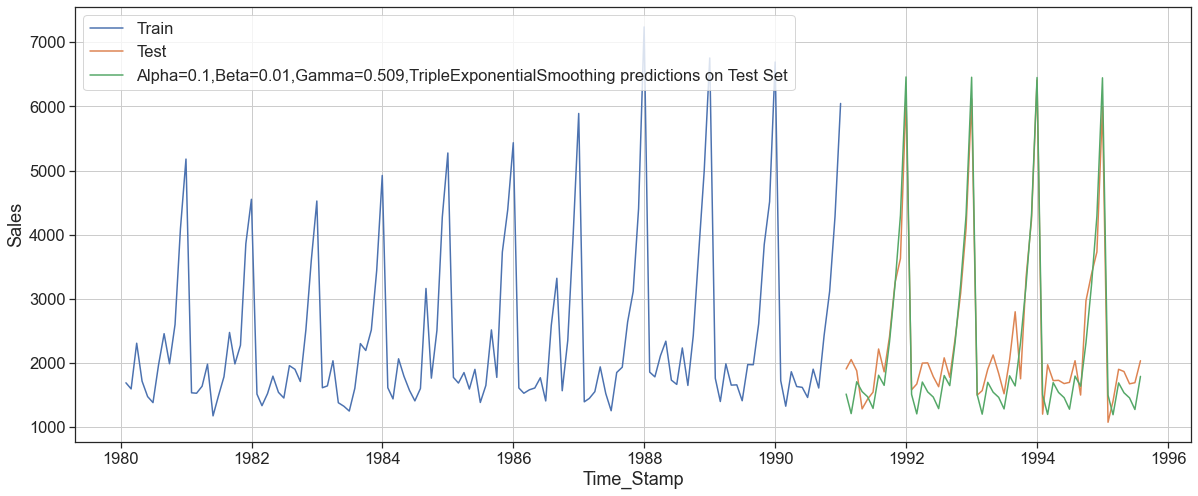

In [78]:
plt.figure(figsize=(20,8))
plt.plot(TES_train['Sparkling'], label='Train')
plt.plot(TES_test['Sparkling'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.1,Beta=0.01,Gamma=0.509,TripleExponentialSmoothing predictions on Test Set')
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.legend(loc='best')
plt.grid();

In [79]:
rmse_model8_train_1=metrics.mean_squared_error(TES_train['Sparkling'],TES_train['auto_predict'],squared=False)
mape_model8_train_1=MAPE(TES_train['Sparkling'],TES_train['auto_predict'])
rmse_model8_test_1=metrics.mean_squared_error(TES_test['Sparkling'],TES_test['auto_predict'],squared=False)
mape_model8_test_1=MAPE(TES_test['Sparkling'],TES_test['auto_predict'])
print("For Alpha=0.1,Beta=0.01,Gamma=0.509, Triple Exponential Smoothing Model forecast on the Train Data,  RMSE is %3.3f" %(rmse_model8_train_1))
print("For Alpha=0.1,Beta=0.01,Gamma=0.509, Triple Exponential Smoothing Model forecast on the Train Data,  MAPE is %3.3f" %(mape_model8_train_1))
print("For Alpha=0.1,Beta=0.01,Gamma=0.509, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_model8_test_1))
print("For Alpha=0.1,Beta=0.01,Gamma=0.509, Triple Exponential Smoothing Model forecast on the Test Data,  MAPE is %3.3f" %(mape_model8_test_1))

For Alpha=0.1,Beta=0.01,Gamma=0.509, Triple Exponential Smoothing Model forecast on the Train Data,  RMSE is 373.052
For Alpha=0.1,Beta=0.01,Gamma=0.509, Triple Exponential Smoothing Model forecast on the Train Data,  MAPE is 10.930
For Alpha=0.1,Beta=0.01,Gamma=0.509, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is 379.696
For Alpha=0.1,Beta=0.01,Gamma=0.509, Triple Exponential Smoothing Model forecast on the Test Data,  MAPE is 12.840


In [80]:
resultsDf_8_1 = pd.DataFrame({'Train RMSE': [rmse_model8_train_1],
                              'Test RMSE': [rmse_model8_test_1],
                              'Train MAPE': [mape_model8_train_1],
                              'Test MAPE': [mape_model8_test_1]}
                           ,index=['Alpha=0.1,Beta=0.01,Gamma=0.509,TripleExponentialSmoothing'])

results = pd.concat([results, resultsDf_8_1])
results

Train RMSE    Test RMSE  \
RegressionOnTime                                    1279.322346  1389.135175   
NaiveModel                                          3867.700802  1327.156057   
SimpleAverageModel                                  1298.483628  1275.081804   
2pointTrailingMovingAverage                                 NaN   813.400684   
4pointTrailingMovingAverage                                 NaN  1156.589694   
6pointTrailingMovingAverage                                 NaN  1283.927428   
9pointTrailingMovingAverage                                 NaN  1346.278315   
Alpha=0.049,SimpleExponentialSmoothing                      NaN  1316.034674   
Alpha=0.1,SimpleExponentialSmoothing                1333.873836  1375.393398   
Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing       1382.520870  1778.564670   
Alpha=0.1,Beta=0.01,Gamma=0.509,TripleExponenti...   373.052373   379.695686   

                                                    Train MAPE  Test MAPE  
RegressionOnTime                                         40.05      50.15  
NaiveModel                                              153.17      32.90  
SimpleAverageModel                                       40.36      38.90  
2pointTrailingMovingAverage                                NaN      19.70  
4pointTrailingMovingAverage                                NaN      35.96  
6pointTrailingMovingAverage                                NaN      43.86  
9pointTrailingMovingAverage                                NaN      46.86  
Alpha=0.049,SimpleExponentialSmoothing                     NaN      45.47  
Alpha=0.1,SimpleExponentialSmoothing                     42.03      49.53  
Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing            44.37      67.20  
Alpha=0.1,Beta=0.01,Gamma=0.509,TripleExponenti...       10.93      12.84

In [81]:
resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],
                              'Test RMSE': [], 'Train MAPE':[], 'Test MAPE':[]})

In [82]:
for i in np.arange(0.1,1,0.1):
    for j in np.arange(0.1,1,0.1):
        for k in np.arange(0.1,1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,
                                                  optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
        
            rmse_model8_train = metrics.mean_squared_error(TES_train['Sparkling'],TES_train['predict',i,j,k],squared=False)
            mape_model8_train = MAPE(TES_train['Sparkling'],TES_train['predict',i,j,k])
            rmse_model8_test = metrics.mean_squared_error(TES_test['Sparkling'],TES_test['predict',i,j,k],squared=False)
            mape_model8_test = MAPE(TES_test['Sparkling'],TES_test['predict',i,j,k])
            
            resultsDf_8_2 = resultsDf_8_2.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
                                                  'Train RMSE':rmse_model8_train,
                                                  'Test RMSE':rmse_model8_test,
                                                  'Train MAPE':mape_model8_train,
                                                  'Test MAPE':mape_model8_test}
                                                 , ignore_index=True)

In [83]:
resultsDf_8_2

Alpha Values  Beta Values  Gamma Values    Train RMSE     Test RMSE  \
0             0.1          0.1           0.1    428.933616  5.070448e+02   
1             0.1          0.1           0.2    400.948971  6.380307e+02   
2             0.1          0.1           0.3    385.679598  7.430712e+02   
3             0.1          0.1           0.4    378.958032  8.079145e+02   
4             0.1          0.1           0.5    378.168418  8.409559e+02   
..            ...          ...           ...           ...           ...   
724           0.9          0.9           0.5   1368.778864  4.334474e+04   
725           0.9          0.9           0.6   2665.992697  1.086727e+05   
726           0.9          0.9           0.7   5652.775823  3.213682e+04   
727           0.9          0.9           0.8  12728.423192  5.956534e+05   
728           0.9          0.9           0.9  32512.307564  1.892655e+06   

     Train MAPE  Test MAPE  
0         13.05      17.83  
1         12.14      22.86  
2         11.73      26.94  
3         11.46      29.33  
4         11.30      30.51  
..          ...        ...  
724       40.52    1575.68  
725       73.63    3938.29  
726      142.86    1120.33  
727      287.04   21885.91  
728      633.86   69202.24  

[729 rows x 7 columns]

In [84]:
resultsDf_8_2f=resultsDf_8_2.sort_values(by=['Test RMSE']).head(5)
resultsDf_8_2f

Alpha Values  Beta Values  Gamma Values  Train RMSE   Test RMSE  \
27            0.1          0.4           0.1  451.554224  342.934716   
90            0.2          0.2           0.1  454.985431  343.121437   
132           0.2          0.6           0.7  492.576190  348.792360   
162           0.3          0.1           0.1  454.346714  390.834811   
18            0.1          0.3           0.1  443.246687  391.304169   

     Train MAPE  Test MAPE  
27        13.49      10.88  
90        14.04      10.62  
132       15.48      10.75  
162       14.04      12.31  
18        13.33      13.79

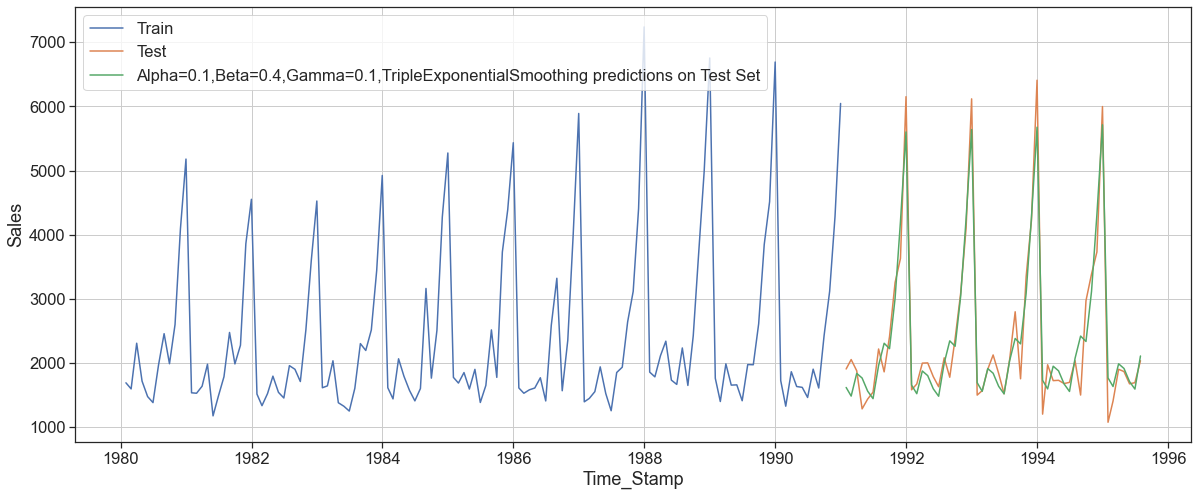

In [85]:
plt.figure(figsize=(20,8))
plt.plot(TES_train['Sparkling'],label='Train')
plt.plot(TES_test['Sparkling'],label='Test')

#The value of alpha and beta is taken like that by python
plt.plot(TES_test['predict',0.1, 0.4, 0.1],label='Alpha=0.1,Beta=0.4,Gamma=0.1,TripleExponentialSmoothing predictions on Test Set')
plt.ylabel("Sales")
plt.xlabel("Time_Stamp")
plt.legend(loc='best')
plt.grid();

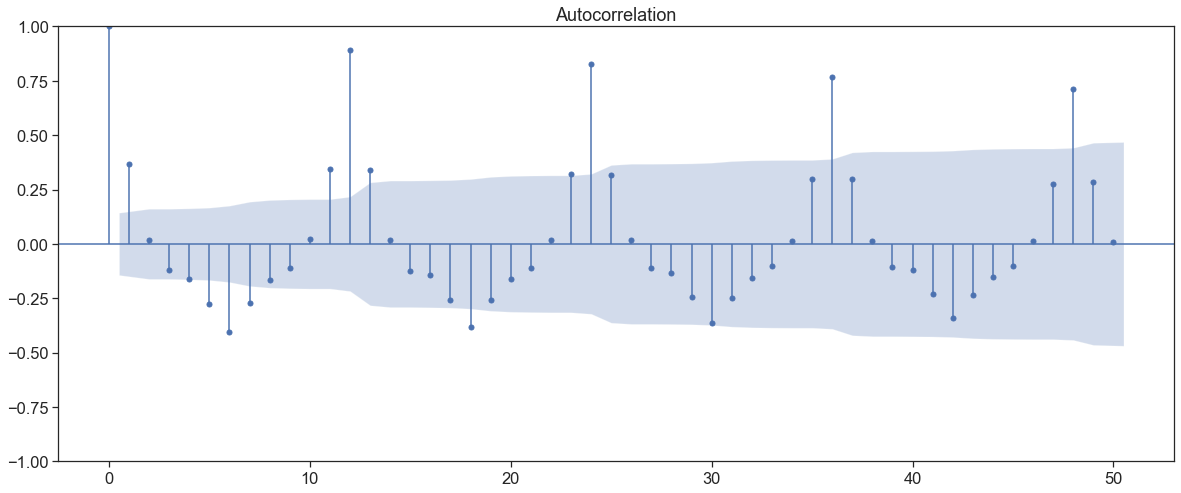

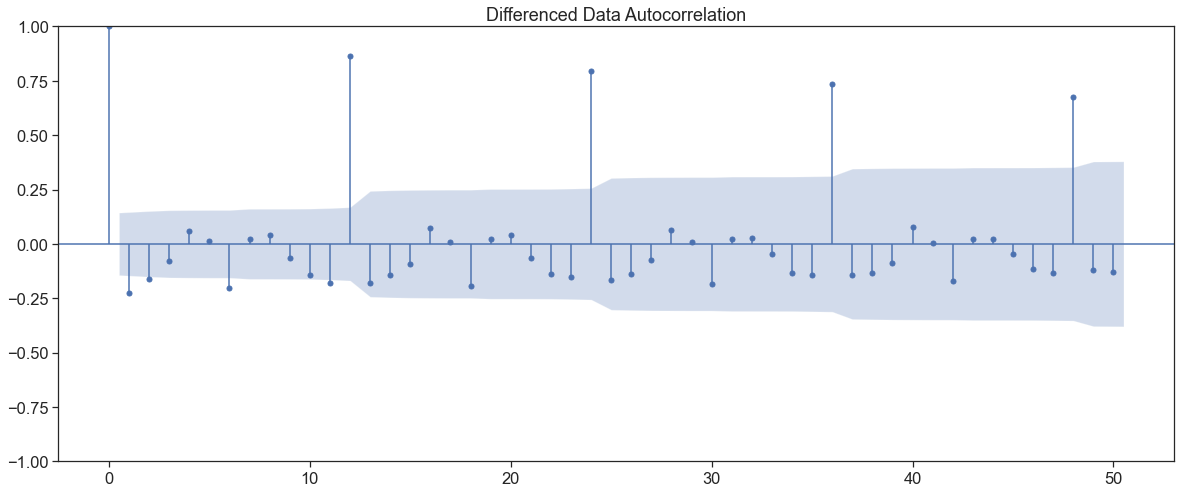

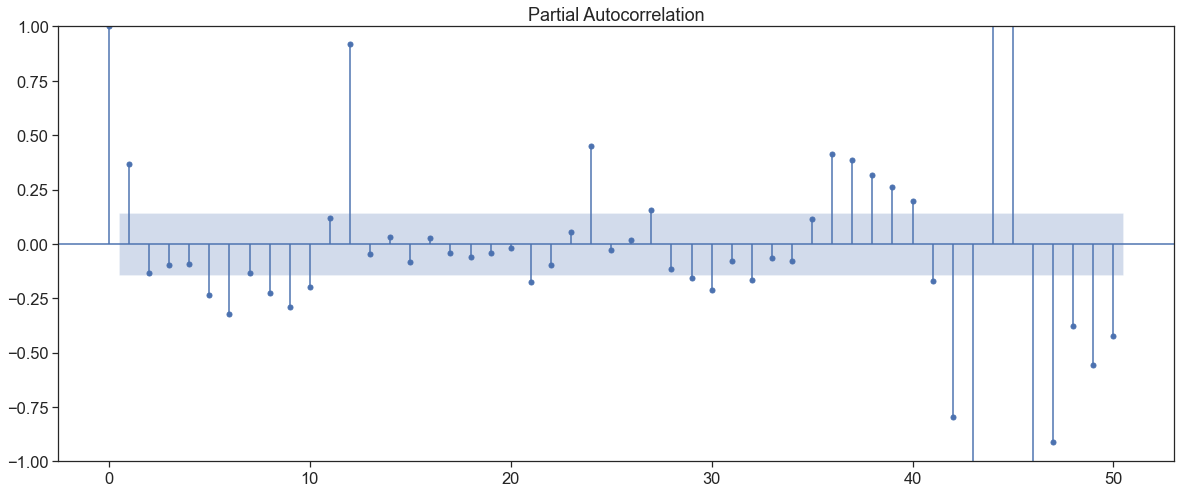

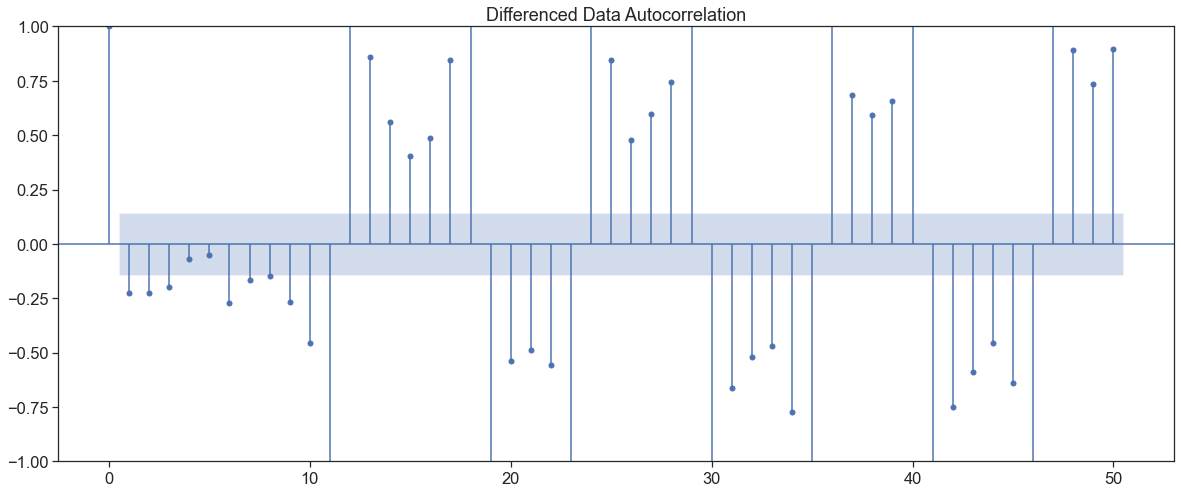

In [86]:
# Plot the Autocorrelation and the Partial Autocorrelation function plots on the whole data.
plot_acf(spark['Sparkling'],lags=50)
plot_acf(spark['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(spark['Sparkling'],lags=50)
plot_pacf(spark['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

In [87]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

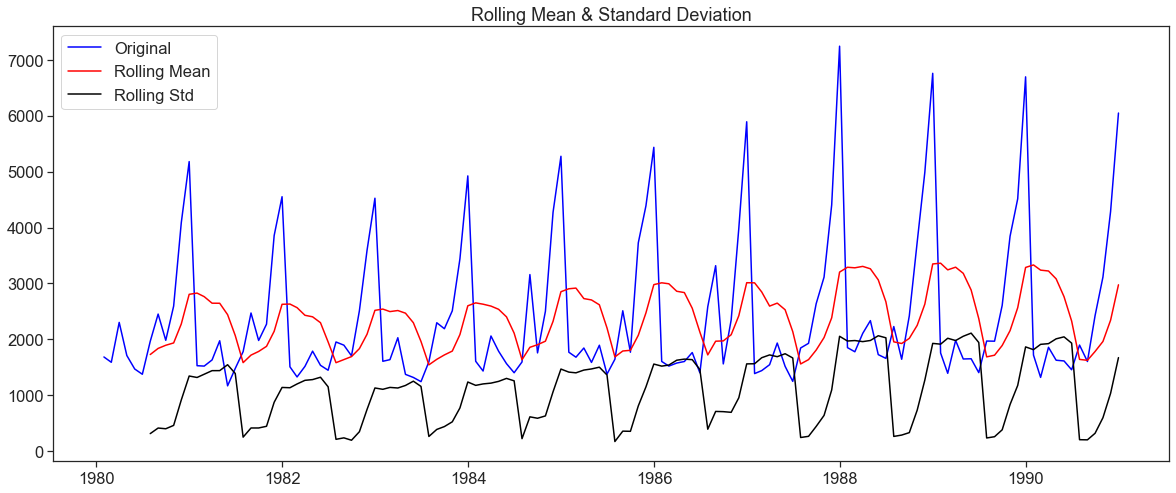

Results of Dickey-Fuller Test:
Test Statistic                  -1.208926
p-value                          0.669744
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64 



In [88]:
test_stationarity(train['Sparkling'])

In [89]:
(train['Sparkling'].diff()).dropna()

Time_Stamp
1980-02-29     -95.0
1980-03-31     713.0
1980-04-30    -592.0
1980-05-31    -241.0
1980-06-30     -94.0
               ...  
1990-08-31    -294.0
1990-09-30     819.0
1990-10-31     692.0
1990-11-30    1170.0
1990-12-31    1761.0
Name: Sparkling, Length: 131, dtype: float64

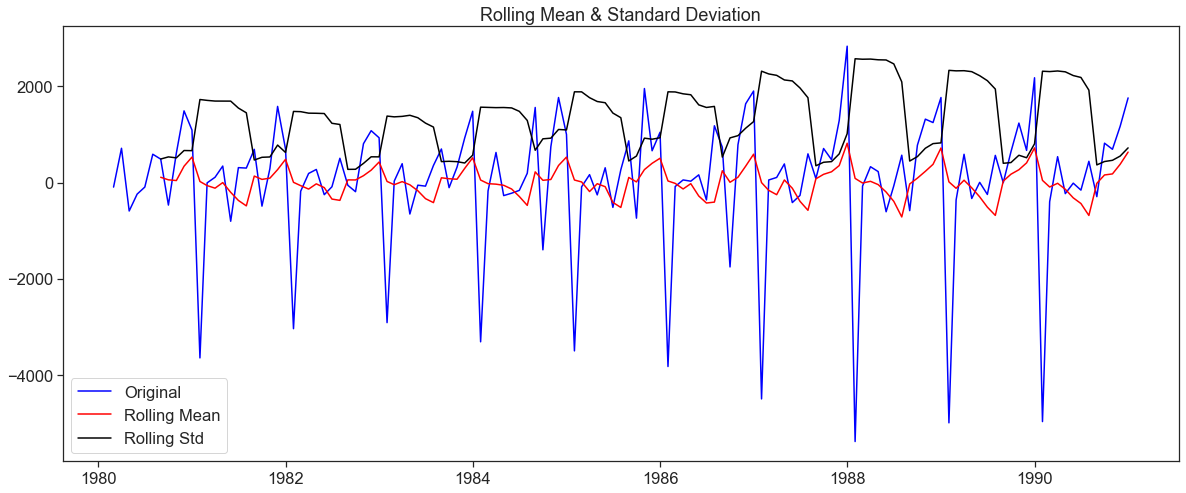

Results of Dickey-Fuller Test:
Test Statistic                -8.005007e+00
p-value                        2.280104e-12
#Lags Used                     1.100000e+01
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64 



In [90]:
test_stationarity(train['Sparkling'].diff().dropna())

In [91]:
#Building ARIMA Model
p = q = range(0, 4)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [92]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
for param in pdq:
    ARIMA_model = ARIMA(train['Sparkling'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:2267.6630357855465
ARIMA(0, 1, 1) - AIC:2263.060015591336
ARIMA(0, 1, 2) - AIC:2234.408323130674
ARIMA(0, 1, 3) - AIC:2233.9948577476116
ARIMA(1, 1, 0) - AIC:2266.6085393190087
ARIMA(1, 1, 1) - AIC:2235.7550946742404
ARIMA(1, 1, 2) - AIC:2234.5272004519366
ARIMA(1, 1, 3) - AIC:2235.6078101124103
ARIMA(2, 1, 0) - AIC:2260.365743968097
ARIMA(2, 1, 1) - AIC:2233.7776262581274
ARIMA(2, 1, 2) - AIC:2213.50921703971
ARIMA(2, 1, 3) - AIC:2232.983057575394
ARIMA(3, 1, 0) - AIC:2257.72337899794
ARIMA(3, 1, 1) - AIC:2235.4989865071907
ARIMA(3, 1, 2) - AIC:2230.7572943437854
ARIMA(3, 1, 3) - AIC:2221.4519770502657


In [93]:
ARIMA_AIC.sort_values(by='AIC',ascending=True)

param          AIC
10  (2, 1, 2)  2213.509217
15  (3, 1, 3)  2221.451977
14  (3, 1, 2)  2230.757294
11  (2, 1, 3)  2232.983058
9   (2, 1, 1)  2233.777626
3   (0, 1, 3)  2233.994858
2   (0, 1, 2)  2234.408323
6   (1, 1, 2)    2234.5272
13  (3, 1, 1)  2235.498987
7   (1, 1, 3)   2235.60781
5   (1, 1, 1)  2235.755095
12  (3, 1, 0)  2257.723379
8   (2, 1, 0)  2260.365744
1   (0, 1, 1)  2263.060016
4   (1, 1, 0)  2266.608539
0   (0, 1, 0)  2267.663036

In [94]:
auto_ARIMA = ARIMA(train['Sparkling'], order=(2,1,2),freq='M')
results_auto_ARIMA = auto_ARIMA.fit()
print(results_auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1101.755
Date:                Wed, 08 Jun 2022   AIC                           2213.509
Time:                        20:44:50   BIC                           2227.885
Sample:                    01-31-1980   HQIC                          2219.351
                         - 12-31-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3121      0.046     28.786      0.000       1.223       1.401
ar.L2         -0.5593      0.072     -7.731      0.000      -0.701      -0.417
ma.L1         -1.9916      0.110    -18.184      0.0

In [95]:
#Predicting Test Data using models
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))
predicted_auto_ARIMA.head()

1991-01-31    4252.375165
1991-02-28    2863.125145
1991-03-31    2043.997950
1991-04-30    1746.212954
1991-05-31    1813.620943
Freq: M, Name: predicted_mean, dtype: float64

In [96]:
rmse_a = metrics.mean_squared_error(test['Sparkling'],predicted_auto_ARIMA,squared=False)
print(rmse_a)

1299.980372953183


In [97]:
result_spark = pd.DataFrame({'RMSE': [rmse_a]}
                           ,index=['ARIMA(2,1,2) with AIC'])

result_spark

RMSE
ARIMA(2,1,2) with AIC  1299.980373

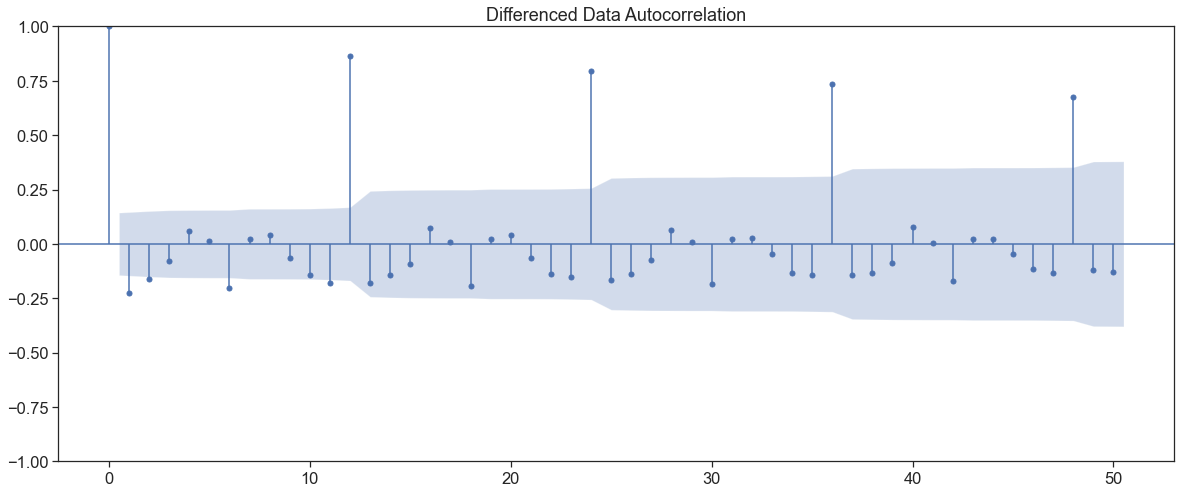

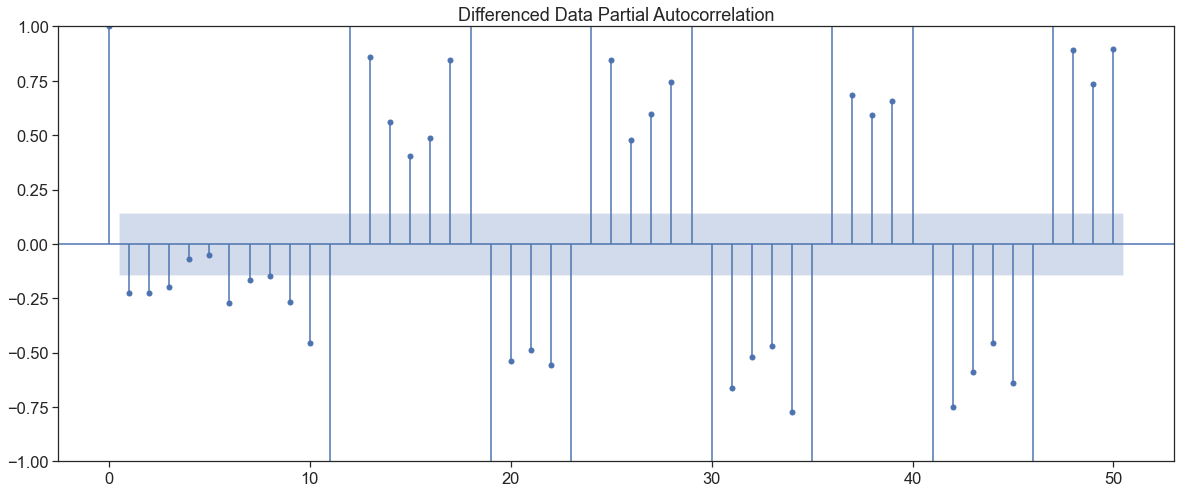

In [98]:
plot_acf(spark['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(spark['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

In [99]:
manual_ARIMA = ARIMA(train['Sparkling'].astype('float64'), order=(3,1,2),freq='M')
results_manual_ARIMA = manual_ARIMA.fit()
print(results_manual_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1109.379
Date:                Wed, 08 Jun 2022   AIC                           2230.757
Time:                        20:44:52   BIC                           2248.008
Sample:                    01-31-1980   HQIC                          2237.767
                         - 12-31-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4326      0.043    -10.044      0.000      -0.517      -0.348
ar.L2          0.3289      0.109      3.005      0.003       0.114       0.543
ar.L3         -0.2385      0.066     -3.591      0.0

In [100]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test))
rmse_p = mean_squared_error(test['Sparkling'],predicted_manual_ARIMA,squared=False)
print(rmse_p)

1281.3202807682173


In [101]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_p]},index=['ARIMA(3,1,2) with ACF/PACF'])
result_spark = pd.concat([result_spark,temp_resultsDf])
result_spark

RMSE
ARIMA(2,1,2) with AIC       1299.980373
ARIMA(3,1,2) with ACF/PACF  1281.320281

In [102]:
p = q = range(0, 4)
P=Q=range(0,4)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (0, 1, 3)(0, 0, 3, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (1, 1, 3)(1, 0, 3, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)
Model: (2, 1, 3)(2, 0, 3, 12)
Model: (3, 1, 0)(3, 0, 0, 12)
Model: (3, 1, 1)(3, 0, 1, 12)
Model: (3, 1, 2)(3, 0, 2, 12)
Model: (3, 1, 3)(3, 0, 3, 12)


In [103]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Sparkling'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic},
                                       ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:2251.3597196862966
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1956.261461684553
SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:1723.1533640236705
SARIMA(0, 1, 0)x(0, 0, 3, 12) - AIC:3650.8176572419843
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1837.4366022456675
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1806.9905301389308
SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:1633.2108735791933
SARIMA(0, 1, 0)x(1, 0, 3, 12) - AIC:6532.776726029097
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:1648.3776153470856
SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:1647.2054158613328
SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:1630.9898053920738
SARIMA(0, 1, 0)x(2, 0, 3, 12) - AIC:3990.005140188904
SARIMA(0, 1, 0)x(3, 0, 0, 12) - AIC:1467.4574095308408
SARIMA(0, 1, 0)x(3, 0, 1, 12) - AIC:1469.187105262566
SARIMA(0, 1, 0)x(3, 0, 2, 12) - AIC:1471.059453006504
SARIMA(0, 1, 0)x(3, 0, 3, 12) - AIC:2858.5655611603
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:2230.1629078505825
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:1923.7688649566726
SARIMA(0, 1, 1)x(0

SARIMA(2, 1, 1)x(1, 0, 3, 12) - AIC:347.6729416252027
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:1577.1235060896936
SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:1573.159584929901
SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:1572.3428689482816
SARIMA(2, 1, 1)x(2, 0, 3, 12) - AIC:3606.5522175962715
SARIMA(2, 1, 1)x(3, 0, 0, 12) - AIC:1402.4673337237525
SARIMA(2, 1, 1)x(3, 0, 1, 12) - AIC:1403.1307561900896
SARIMA(2, 1, 1)x(3, 0, 2, 12) - AIC:1403.8240222791153
SARIMA(2, 1, 1)x(3, 0, 3, 12) - AIC:2836.026018979068
SARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:2176.8681144920774
SARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:1892.2372645539306
SARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:1661.5523434197971
SARIMA(2, 1, 2)x(0, 0, 3, 12) - AIC:7148.721420176137
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1757.2140931725573
SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1725.3955655750103
SARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:1557.3404019463708
SARIMA(2, 1, 2)x(1, 0, 3, 12) - AIC:7110.050878551588
SARIMA(2, 1, 2)x(2, 0, 0, 12) - AIC:1576.0457450685449
SARIMA(2, 1, 2)

In [104]:
SARIMA_AIC.sort_values(by=['AIC']).head()

param       seasonal         AIC
99   (1, 1, 2)  (0, 0, 3, 12)        14.0
147  (2, 1, 1)  (0, 0, 3, 12)        14.0
215  (3, 1, 1)  (1, 0, 3, 12)  208.047774
151  (2, 1, 1)  (1, 0, 3, 12)  347.672942
251  (3, 1, 3)  (2, 0, 3, 12)  349.867995

In [105]:
auto_SARIMA_6 = sm.tsa.statespace.SARIMAX(train['Sparkling'].values,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA_6 = auto_SARIMA_6.fit(maxiter=1000)
print(results_auto_SARIMA_6.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -855.998
Date:                              Wed, 08 Jun 2022   AIC                           1723.995
Time:                                      20:53:18   BIC                           1740.517
Sample:                                           0   HQIC                          1730.702
                                              - 132                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6204      0.280     -2.212      0.027      -1.170      -0.071
ma.L1         -0.12

In [106]:
predicted_auto_SARIMA_6 = results_auto_SARIMA_6.get_forecast(steps=len(test))

In [107]:
predicted_auto_SARIMA_6.summary_frame(alpha=0.05).head()

y         mean     mean_se  mean_ci_lower  mean_ci_upper
0  1327.497429  381.069785     580.614375    2074.380483
1  1236.667714  393.150571     466.106755    2007.228674
2  1593.470836  393.485051     822.254307    2364.687365
3  1537.900676  399.006615     755.862081    2319.939272
4  1354.934581  400.554591     569.862009    2140.007153

In [108]:
rmse_sp = mean_squared_error(test['Sparkling'],predicted_auto_SARIMA_6.predicted_mean,squared=False)
print(rmse_sp)

583.52413484973


In [109]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_sp]},index=['SARIMA(1,1,2)(1,0,1,12) with AIC'])
result_spark = pd.concat([result_spark,temp_resultsDf])
result_spark 

RMSE
ARIMA(2,1,2) with AIC             1299.980373
ARIMA(3,1,2) with ACF/PACF        1281.320281
SARIMA(1,1,2)(1,0,1,12) with AIC   583.524135

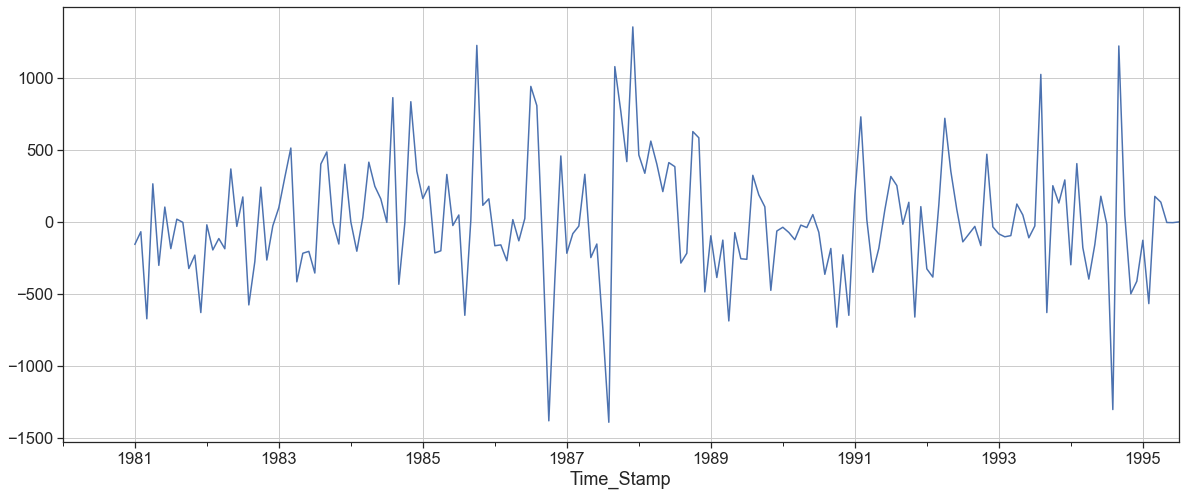

In [110]:
(spark['Sparkling'].diff(12)).plot()
plt.grid();

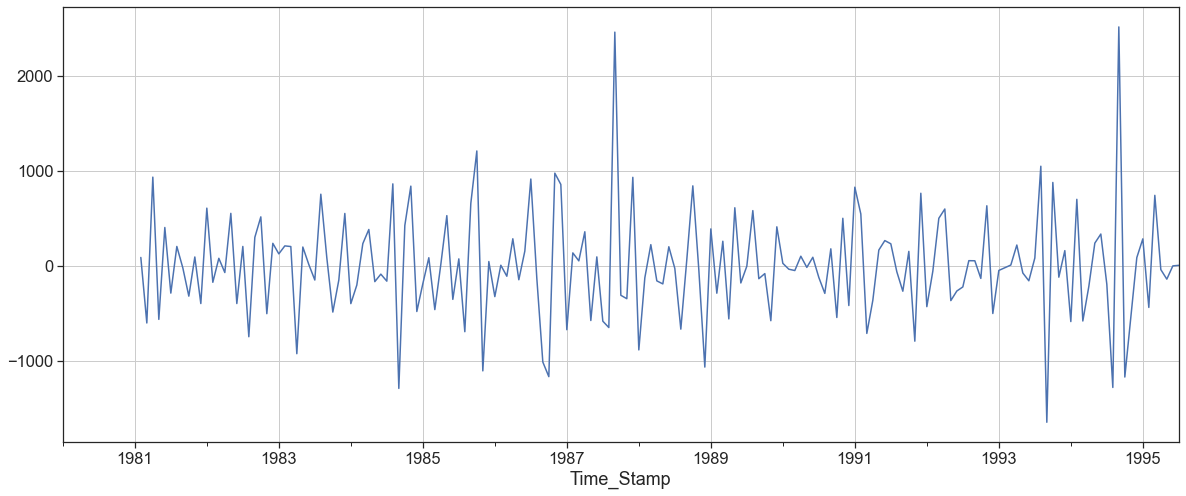

In [111]:
(spark['Sparkling'].diff(12)).diff().plot()
plt.grid();

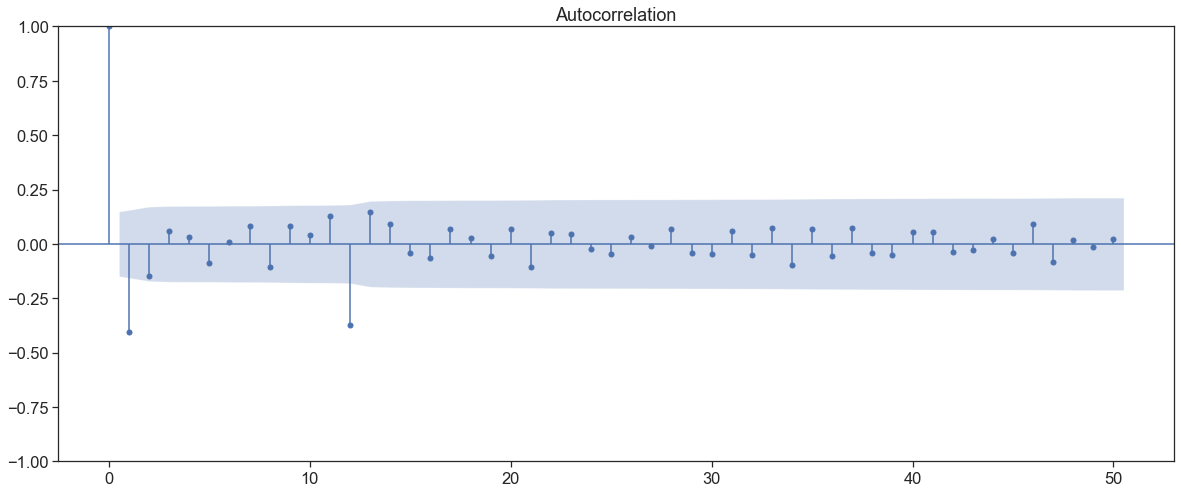

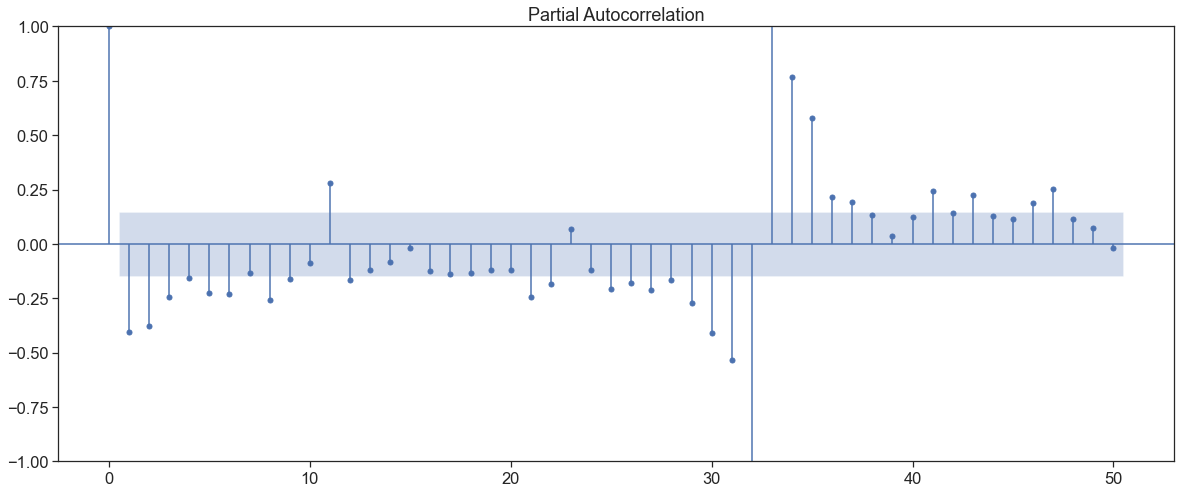

In [112]:
plot_acf((spark['Sparkling'].diff(12).dropna()).diff(1).dropna(),lags=50)
plot_pacf((spark['Sparkling'].diff(12).dropna()).diff(1).dropna(),lags=50);

In [113]:
manual_SARIMA_6 = sm.tsa.statespace.SARIMAX(train['Sparkling'].values,
                                order=(3,1,2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_SARIMA_6 = manual_SARIMA_6.fit(maxiter=1000)
print(results_manual_SARIMA_6.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -855.786
Date:                              Wed, 08 Jun 2022   AIC                           1727.572
Time:                                      20:53:19   BIC                           1749.600
Sample:                                           0   HQIC                          1736.514
                                              - 132                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6473      0.291     -2.222      0.026      -1.218      -0.076
ar.L2         -0.05

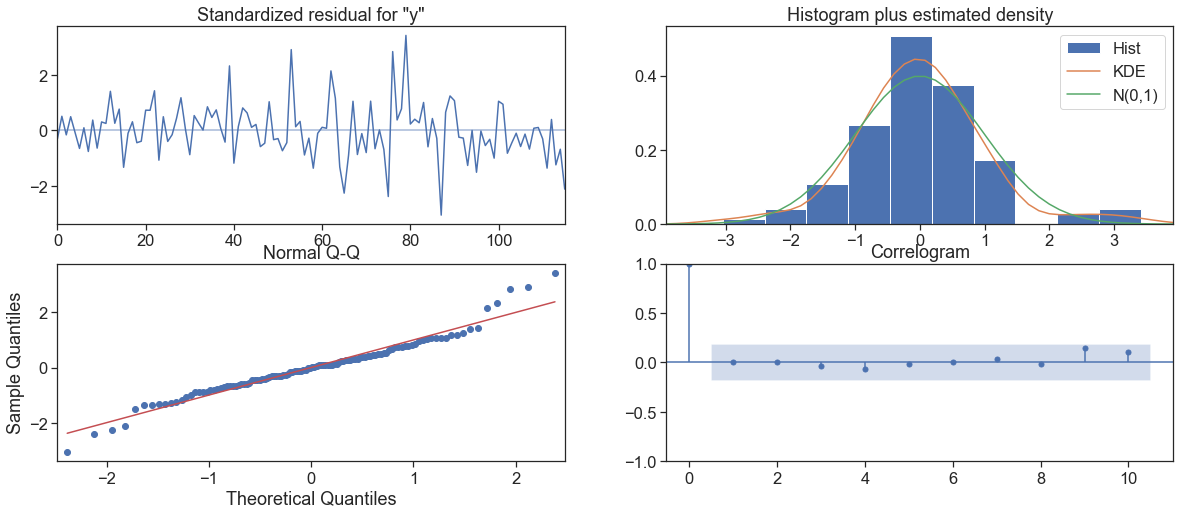

In [114]:
results_manual_SARIMA_6.plot_diagnostics()
plt.show()

In [115]:
predicted_manual_SARIMA_6 = results_manual_SARIMA_6.get_forecast(steps=len(test))

In [116]:
predicted_manual_SARIMA_6.summary_frame(alpha=0.05).head()
rmse_spm = mean_squared_error(test['Sparkling'],predicted_manual_SARIMA_6.predicted_mean,squared=False)
print(rmse_spm)

609.0009247200458


In [117]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_spm]},index=['SARIMA(3,1,2)(1,0,1,12) with ACF/PACF'])
result_spark = pd.concat([result_spark,temp_resultsDf])

result_spark

RMSE
ARIMA(2,1,2) with AIC                  1299.980373
ARIMA(3,1,2) with ACF/PACF             1281.320281
SARIMA(1,1,2)(1,0,1,12) with AIC        583.524135
SARIMA(3,1,2)(1,0,1,12) with ACF/PACF   609.000925

In [118]:
full_data_model = sm.tsa.statespace.SARIMAX(spark['Sparkling'],
                                order=(1,1,2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
print(results_full_data_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            Sparkling   No. Observations:                  187
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1257.987
Date:                              Wed, 08 Jun 2022   AIC                           2527.973
Time:                                      20:53:20   BIC                           2546.823
Sample:                                  01-31-1980   HQIC                          2535.622
                                       - 07-31-1995                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5993      0.302     -1.986      0.047      -1.191      -0.008
ma.L1         -0.22

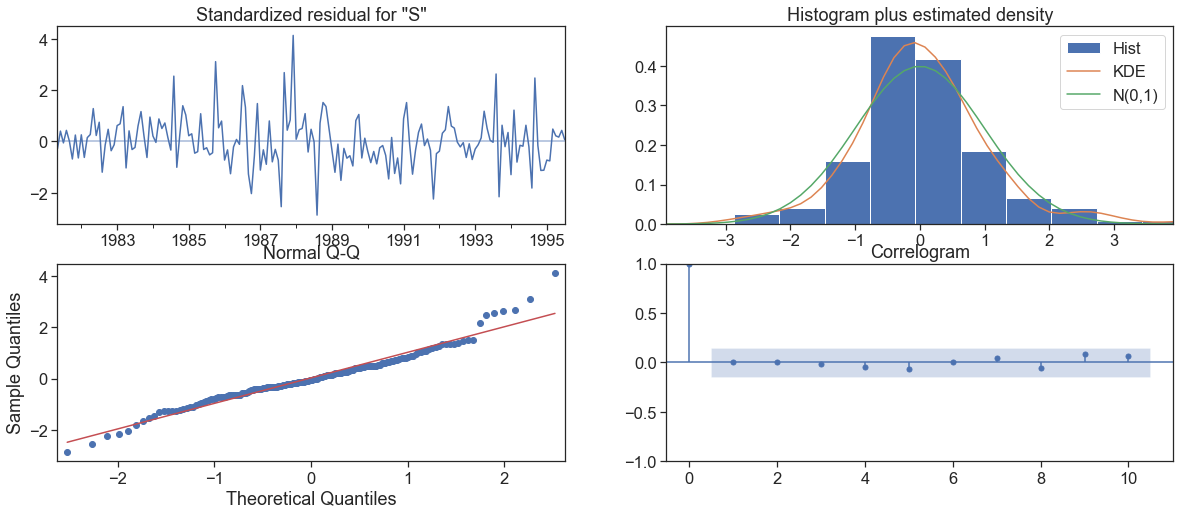

In [119]:
results_full_data_model.plot_diagnostics();

In [120]:
predicted_manual_SARIMA_6_full_data = results_full_data_model.get_forecast(steps=12)

In [121]:
predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).head()

Sparkling          mean     mean_se  mean_ci_lower  mean_ci_upper
1995-08-31  1875.932147  373.095462    1144.678479    2607.185815
1995-09-30  2424.976653  378.532675    1683.066243    3166.887063
1995-10-31  3302.729209  378.533393    2560.817393    4044.641026
1995-11-30  4006.936439  380.497302    3261.175431    4752.697447
1995-12-31  6268.208717  380.830073    5521.795490    7014.621945

In [122]:
rmse_f = mean_squared_error(spark['Sparkling'],results_full_data_model.fittedvalues,squared=False)
print('RMSE of the Full Model',rmse_f)

RMSE of the Full Model 534.632401087851


In [123]:
pred_full_manual_SARIMA_date = predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).set_index(pd.date_range(start='1995-08-01',end='1996-08-01', freq='M'))

In [124]:
pred_full_manual_SARIMA_date

Sparkling          mean     mean_se  mean_ci_lower  mean_ci_upper
1995-08-31  1875.932147  373.095462    1144.678479    2607.185815
1995-09-30  2424.976653  378.532675    1683.066243    3166.887063
1995-10-31  3302.729209  378.533393    2560.817393    4044.641026
1995-11-30  4006.936439  380.497302    3261.175431    4752.697447
1995-12-31  6268.208717  380.830073    5521.795490    7014.621945
1996-01-31  1230.481527  381.972180     481.829810    1979.133244
1996-02-29  1556.044408  382.569305     806.222348    2305.866468
1996-03-31  1802.972565  383.468857    1051.387417    2554.557713
1996-04-30  1779.562671  384.177473    1026.588659    2532.536682
1996-05-31  1624.305492  384.995085     869.728990    2378.881994
1996-06-30  1562.470945  385.744053     806.426494    2318.515396
1996-07-31  1990.940986  386.531250    1233.353658    2748.528315

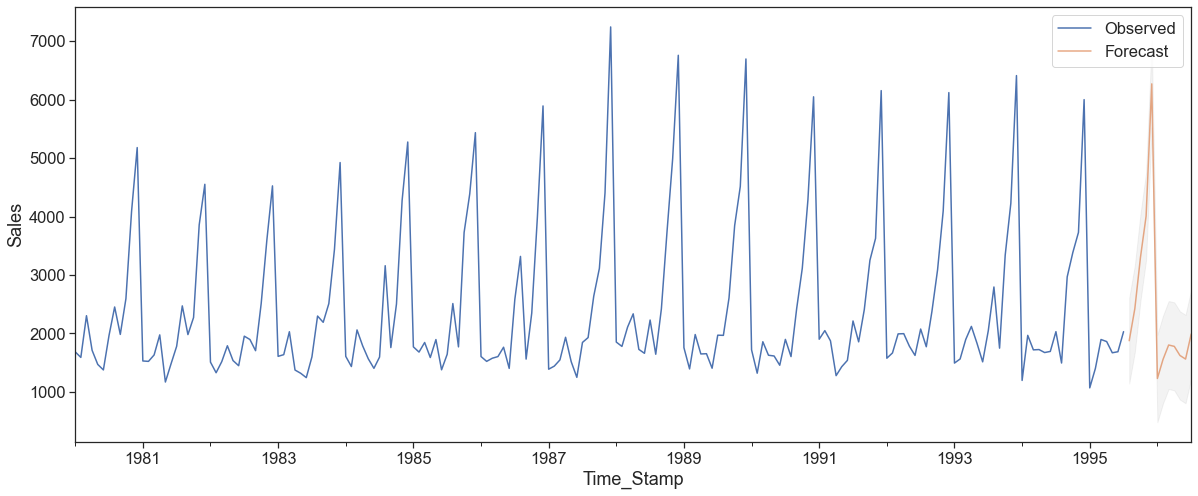

In [125]:
axis = spark['Sparkling'].plot(label='Observed')
pred_full_manual_SARIMA_date['mean'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(pred_full_manual_SARIMA_date.index, pred_full_manual_SARIMA_date['mean_ci_lower'], 
                  pred_full_manual_SARIMA_date['mean_ci_upper'], color='k', alpha=.05)
axis.set_xlabel('Time_Stamp')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()

In [126]:
result_spark

RMSE
ARIMA(2,1,2) with AIC                  1299.980373
ARIMA(3,1,2) with ACF/PACF             1281.320281
SARIMA(1,1,2)(1,0,1,12) with AIC        583.524135
SARIMA(3,1,2)(1,0,1,12) with ACF/PACF   609.000925

In [127]:
results1 = pd.DataFrame({'Test RMSE': [rmse_model1_test,rmse_model2_test,rmse_model3_test,rmse_model4_test_2,
                                       rmse_model4_test_4,rmse_model4_test_6,rmse_model4_test_9,mape_model5_test_1,
                                       resultsDf_6['Test RMSE'][0],resultsDf_7['Test RMSE'][0],
                                      rmse_model8_test_1,resultsDf_8_2f.iloc[0,4],rmse_a,rmse_p,rmse_sp,rmse_spm,rmse_f]},
                       index=['RegressionOnTime','NaiveModel','SimpleAverageModel','2pointTrailingMovingAverage',
                              '4pointTrailingMovingAverage','6pointTrailingMovingAverage','9pointTrailingMovingAverage',
                              'Alpha=0.049,SimpleExponentialSmoothing','Alpha=0.1,SimpleExponentialSmoothing using Brute',
                              'Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing using Brute',
                              'Alpha=0.1,Beta=0.01,Gamma=0.509,TripleExponentialSmoothing',
                              'Alpha=0.1,Beta=0.4,Gamma=0.1,TripleExponentialSmoothing using Brute',
                              'ARIMA(2,1,2) with AIC','ARIMA(3,1,2) using ACF/PACF',
                              'SARIMA(1,1,2)(1,0,1,12) with AIC','SARIMA(3,1,2)(1,0,1,12) using ACF/PACF',
                              'RMSE of the Full Model'
                             ])

In [128]:
results1

Test RMSE
RegressionOnTime                                    1389.135175
NaiveModel                                          1327.156057
SimpleAverageModel                                  1275.081804
2pointTrailingMovingAverage                          813.400684
4pointTrailingMovingAverage                         1156.589694
6pointTrailingMovingAverage                         1283.927428
9pointTrailingMovingAverage                         1346.278315
Alpha=0.049,SimpleExponentialSmoothing                45.470000
Alpha=0.1,SimpleExponentialSmoothing using Brute    1375.393398
Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing u...  1778.564670
Alpha=0.1,Beta=0.01,Gamma=0.509,TripleExponenti...   379.695686
Alpha=0.1,Beta=0.4,Gamma=0.1,TripleExponentialS...   342.934716
ARIMA(2,1,2) with AIC                               1299.980373
ARIMA(3,1,2) using ACF/PACF                         1281.320281
SARIMA(1,1,2)(1,0,1,12) with AIC                     583.524135
SARIMA(3,1,2)(1,0,1,12) using ACF/PACF               609.000925
RMSE of the Full Model                               534.632401

In [129]:
SES_full_rose = ExponentialSmoothing(spark, trend='additive', seasonal='multiplicative').fit(smoothing_level=0.049)

In [130]:
print(SES_full_rose.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                Sparkling   No. Observations:                  187
Model:             ExponentialSmoothing   SSE                       23201816.699
Optimized:                         True   AIC                           2225.254
Trend:                         Additive   BIC                           2276.952
Seasonal:                Multiplicative   AICC                          2229.326
Seasonal Periods:                    12   Date:                 Wed, 08 Jun 2022
Box-Cox:                          False   Time:                         20:53:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0490000                alpha                False
smoothing_trend          

In [131]:
predicted_SES_full_data = SES_full_rose.forecast(12)

In [132]:
predicted_SES_full_data

1995-08-31    1939.496330
1995-09-30    2380.206773
1995-10-31    3221.428784
1995-11-30    3951.799258
1995-12-31    6054.558171
1996-01-31    1353.099295
1996-02-29    1609.885038
1996-03-31    1842.354771
1996-04-30    1807.313664
1996-05-31    1658.911657
1996-06-30    1578.633965
1996-07-31    1996.484965
Freq: M, dtype: float64

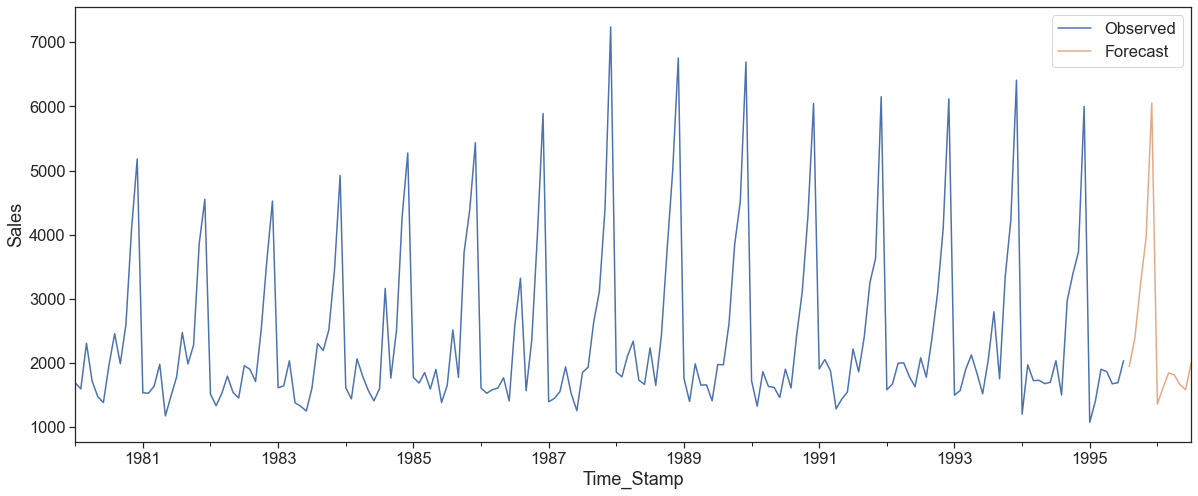

In [133]:
plt.figure(figsize=(20,8))
axis = spark['Sparkling'].plot(label='Observed')
predicted_SES_full_data.plot(ax=axis, label='Forecast', alpha=0.7)
axis.set_xlabel('Time_Stamp')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()


In [134]:
tripleES_full_spark = ExponentialSmoothing(spark, trend='additive', seasonal='multiplicative').fit(smoothing_level=0.1, 
                                                                                                 smoothing_trend=0.4, 
                                                                                                 smoothing_seasonal=0.1)

In [135]:
print(tripleES_full_spark.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                Sparkling   No. Observations:                  187
Model:             ExponentialSmoothing   SSE                       27583711.074
Optimized:                         True   AIC                           2257.604
Trend:                         Additive   BIC                           2309.302
Seasonal:                Multiplicative   AICC                          2261.676
Seasonal Periods:                    12   Date:                 Wed, 08 Jun 2022
Box-Cox:                          False   Time:                         20:53:22
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_trend          

In [136]:
predicted_TES_full_data = tripleES_full_spark.forecast(12)

In [137]:
predicted_TES_full_data

1995-08-31    2090.843600
1995-09-30    2197.261660
1995-10-31    3056.042480
1995-11-30    4041.140189
1995-12-31    5890.993625
1996-01-31    1528.944953
1996-02-29    1602.949022
1996-03-31    1885.385633
1996-04-30    1818.792961
1996-05-31    1667.901259
1996-06-30    1552.127884
1996-07-31    2042.084447
Freq: M, dtype: float64

In [138]:
plt.figure(figsize=(20,8))
axis = spark['Sparkling'].plot(label='Observed')
predicted_TES_full_data.plot(ax=axis, label='Forecast', alpha=0.7)
axis.set_xlabel('Time_Stamp')
axis.set_ylabel('Sparkling Sales')
plt.legend(loc='best')
plt.show()